<a href="https://colab.research.google.com/github/irislemus/Challenge-TelecomX-/blob/main/Final_TelecomX_2_LATAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------------------------------------------------------
#**PREDICCIÓN DE CANCELACIÓN (CHURN)**

#**TELECOM X - Parte 2**

Objetivo : Desarrollar modelos predictivos capaces de prever qué clientes tienen mayor probabilidad de cancelar sus servicios.
--------------------------------------------------------------------------------

#EDA y Preprocesamiento

--------------------------------------------------------------------------------
Carga de datos

--------------------------------------------------------------------------------

In [ ]:
# Importar librerías

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')


# Carga de datos

df = pd.read_csv('/content/datos_tLX_tratados.csv')

df.head()


,Cliente_ID,Evasion,Genero,Adulto_Mayor,Pareja,Dependientes,Meses_Contrato,Servicio_Telefonico,Multiples_Lineas,Servicio_Internet,...,Proteccion_Dispositivo,Soporte_Tecnico,Streaming_TV,Streaming_Peliculas,Tipo_Contrato,Factura_Electronica,Metodo_Pago,Factura_Mensual,Factura_Total,Cuentas_Diarias
0,0002-ORFBO,0,Female,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,Male,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month to month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,Male,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month to month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,Male,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month to month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,Female,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month to month,1,Mailed check,83.9,267.40,2.796667


--------------------------------------------------------------------------------
 Exploración inicial y limpieza


--------------------------------------------------------------------------------

In [ ]:
def analisis_exploratorio(df: pd.DataFrame, corr_threshold: float = 0.85) -> pd.DataFrame:

   # Eliminar columna customerID si existe
    if 'Cliente_ID' in df.columns:
        df = df.drop(columns=['Cliente_ID'])
        print("Columna 'Cliente_ID' eliminada (identificador no predictivo).")

    print('\n--- Dimensiones del dataset ---')
    print(df.shape)

    print('\n--- Primeras filas ---')
    print(df.head())

    print('\n--- Tipos de datos ---')
    print(df.dtypes)

    print('\n--- Valores nulos por columna ---')
    print(df.isnull().sum())

    print('\n--- Estadísticas numéricas ---')
    print(df.describe(include=[np.number]).T)

    print('\n--- Estadísticas categóricas ---')
    print(df.describe(include=['object', 'category']).T)

    # Distribución y diagnóstico del target (Evasion)
    if 'Evasion' in df.columns:
        print('\n--- Distribución de la variable objetivo (Evasion) ---')
        print(df['Evasion'].value_counts(dropna=False))

        # 📊 Diagnóstico de balanceo de clases
        conteo = df['Evasion'].value_counts()
        total = len(df)
        proporciones = conteo / total

        print("\n📊 Diagnóstico de Balanceo de Clases:")
        for clase, prop in proporciones.items():
            print(f" - Clase {clase}: {conteo[clase]} ({prop*100:.2f}%)")

        # Visualización balance
        plt.figure(figsize=(6,4))
        sns.countplot(x='Evasion', data=df, palette="pastel")
        plt.title("Distribución de Evasión")
        plt.xlabel("Evasión")
        plt.ylabel("Clientes")
        plt.xticks([0, 1], ['No', 'Sí'])
        plt.tight_layout()
        plt.show()

        # Validación de rango esperado
        prop_positiva = proporciones.get(1, 0)
        if 0.20 <= prop_positiva <= 0.35:
            print(f"✅ Proporción de positivos ({prop_positiva*100:.2f}%) está en el rango típico (20%-35%).")
        else:
            print(f"⚠️ Proporción de positivos ({prop_positiva*100:.2f}%) está FUERA del rango típico.")
            print("   Recomendación: aplicar técnicas de balanceo (SMOTE, undersampling o class_weight).")


    # Visualizaciones combinadas (Histogramas + Boxplots)
    variables_numericas = ['Factura_Mensual', 'Factura_Total', 'Cuentas_Diarias']
    for col in variables_numericas:
        if col in df.columns:
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            # Histograma con KDE
            sns.histplot(df[col].dropna(), kde=True, color='skyblue', ax=axes[0])
            axes[0].set_title(f'Distribución de {col}')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frecuencia')

            # Boxplot por Evasion
            if 'Evasion' in df.columns:
                sns.boxplot(x='Evasion', y=col, data=df, palette='coolwarm', ax=axes[1])
                axes[1].set_title(f'{col} por Evasion')

            plt.tight_layout()
            plt.show()

    # Matriz de correlación para variables numéricas
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) > 1:
        plt.figure(figsize=(10, 8))
        corr_matrix = df[num_cols].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Matriz de correlaciones (numéricas)')
        plt.tight_layout()
        plt.show()

        # Eliminación de variables muy correlacionadas
        to_drop = set()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                    colname = corr_matrix.columns[i]
                    to_drop.add(colname)

        if to_drop:
            print(f"\nVariables eliminadas por alta correlación (> {corr_threshold}): {to_drop}")
            df = df.drop(columns=list(to_drop))
        else:
            print(f"\nNo se eliminaron variables por correlación (> {corr_threshold})")

    print('\n--- Fin EDA con eliminación de variables ---')
    return df


Columna 'Cliente_ID' eliminada (identificador no predictivo).

--- Dimensiones del dataset ---
(7267, 21)

--- Primeras filas ---
   Evasion  Genero  Adulto_Mayor  Pareja  Dependientes  Meses_Contrato  \
0        0  Female             0       1             1               9   
1        0    Male             0       0             0               9   
2        1    Male             0       0             0               4   
3        1    Male             1       1             0              13   
4        1  Female             1       1             0               3   

   Servicio_Telefonico Multiples_Lineas Servicio_Internet Seguridad_EnLinea  \
0                    1               No               DSL                No   
1                    1              Yes               DSL                No   
2                    1               No       Fiber optic                No   
3                    1               No       Fiber optic                No   
4                    1        

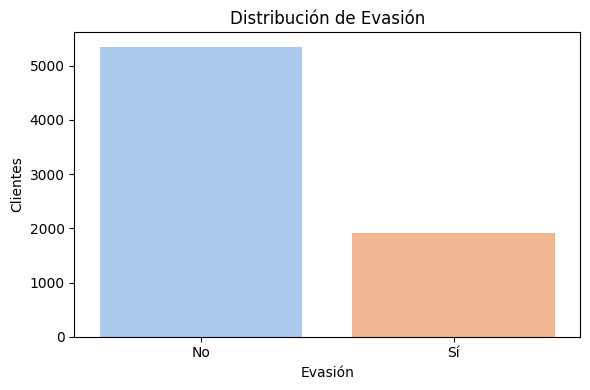

✅ Proporción de positivos (26.38%) está en el rango típico (20%-35%).


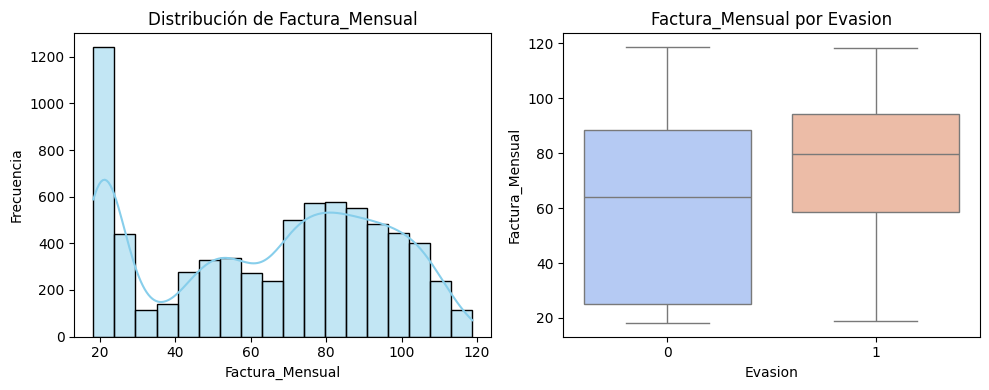

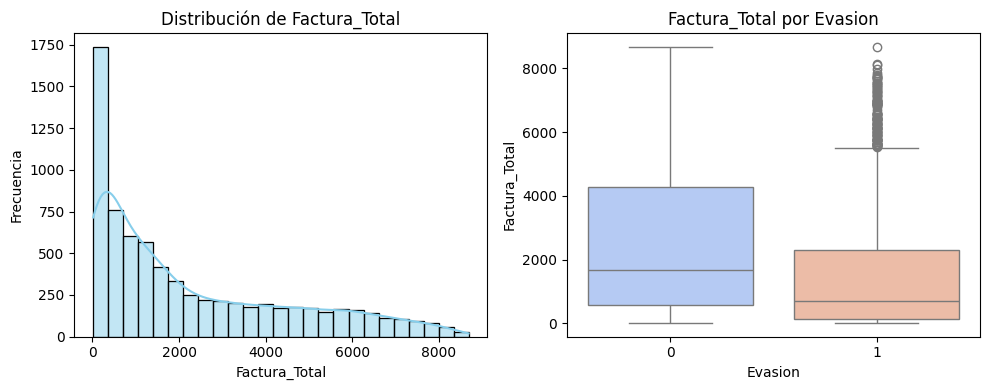

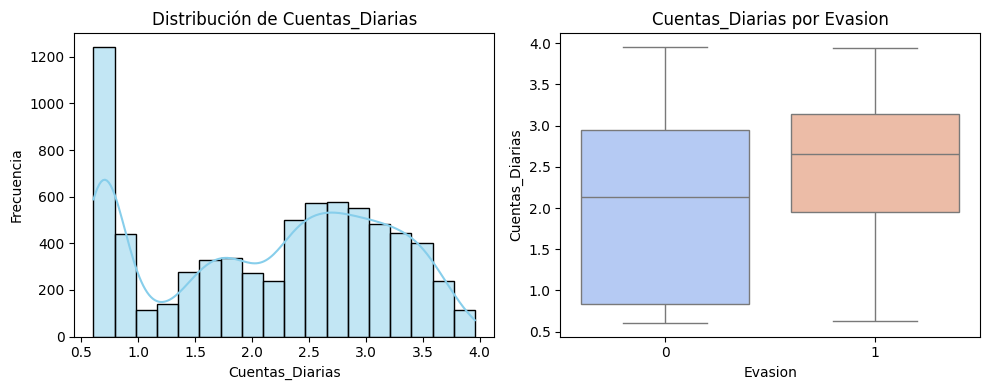

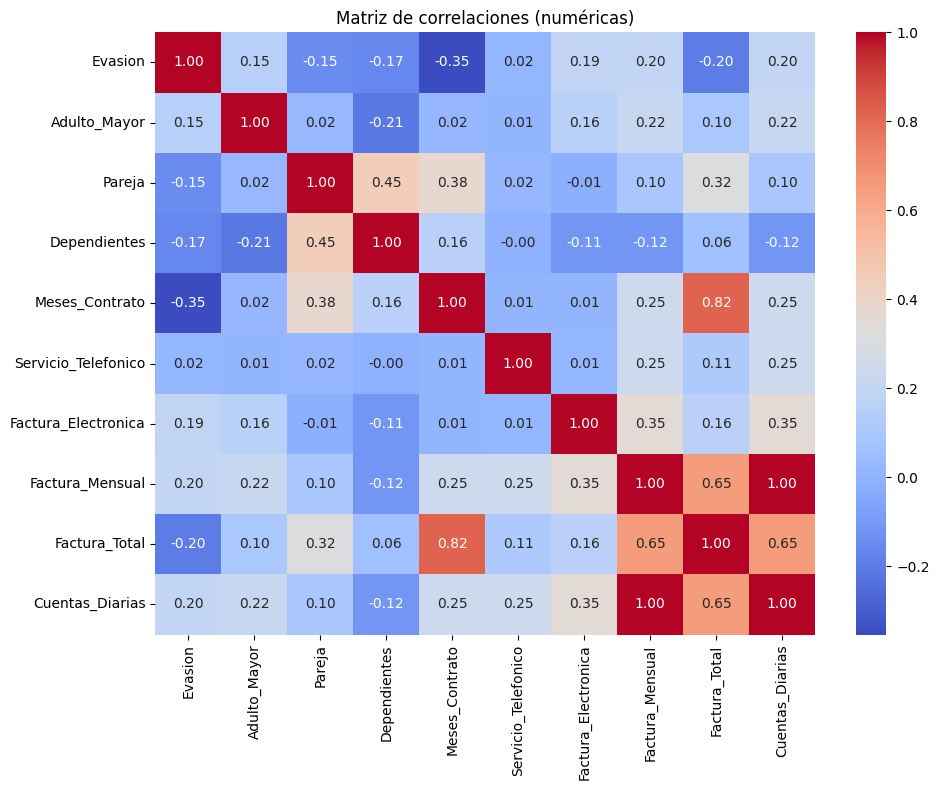


Variables eliminadas por alta correlación (> 0.85): {'Cuentas_Diarias'}

--- Fin EDA con eliminación de variables ---


In [ ]:
df_limpio = analisis_exploratorio(df, corr_threshold=0.85)

**Comentarios**

* Distribución de clases` (Evasion):`

  Clase 0 (No cancelan): 73.62%.

  Clase 1 (Sí cancelan): 26.38%.

  Aunque la distribución de las clases está dentro del rango típico esperado (20%-35%), lo cual es favorable, se puede ver cierto desbalance entre los que sí y no evanden → lo consideraremos en la fase de balanceo (segunda iteración).

* `(Factura_Mensual)` :
Clientes que evadieron tienen una mediana más alta y un rango más concentrado y los clientes que se mantuvieron tienen una mediana más bajay mayor variabilidad.
Facturas altas incrementan el riesgo de evasión, posiblemente por percepción de costo elevado.

* `(Factura_Total)`: Sesgo positivo (derecha). La mayoría de los clientes acumula facturas bajas, mientras que pocos clientes acumulan montos muy altos.

  Clientes no evasores tienen una mediana mucho mayor y clientes evasores muestran facturas totales mucho menores, aunque algunos casos aislados acumulan valores muy altos y aún así cancelan.
  Clientes con baja inversión acumulada son más propensos a cancelar, lo que indica falta de lealtad consolidada.

* `(Cuentas_Diarias)`: Clientes evasores tienen una mediana más alta y los clientes que permanecen tienen una mediana menor
se podría decir que el mayor uso/interacción diaria está asociado con más evasión, posiblemente porque más interacciones generan mayor exposición a fallas o fricciones.

* `(Meses_Contrato)` : Relación negativa fuerte con evasión (-0.35). A mayor antigüedad, menor evasión. La lealtad y permanencia son factores protectores.

* variables eliminadas

 Cliente_ID no contamine el modelo.

  Eliminamos Cuentas_Diarias, ya que estaba 100% correlacionada con Factura_Mensual.


--------------------------------------------------------------------------------
Análisis de categóricas vs evasión

--------------------------------------------------------------------------------

In [ ]:

categoricas_clave = [
    "Tipo_Contrato",
    "Metodo_Pago",
    "Genero",
    "Multiples_Lineas",
    "Servicio_Internet",
    "Seguridad_EnLinea",
    "Respaldo_EnLinea",
    "Proteccion_Dispositivo",
    "Soporte_Tecnico",
    "Streaming_TV",
    "Streaming_Peliculas"

]

def resumen_categoricas(df_limpio, variables, target="Evasion"):
    resumen = {}

    for var in variables:
        if var not in df_limpio.columns:
            print(f"⚠️ La variable {var} no está en el dataset, se omite.")
            continue

        # Calcular proporciones
        prop_df_limpio = (
            df_limpio.groupby([var, target]).size().reset_index(name="count")
        )
        prop_df_limpio["proporcion"] = prop_df_limpio.groupby(var)["count"].transform(lambda x: x / x.sum())

        # Pivot para leer más fácil
        pivot = prop_df_limpio.pivot(index=var, columns=target, values="proporcion").fillna(0)
        counts = df_limpio[var].value_counts()

        resumen_texto = []
        for categoria in pivot.index:
            no_evasion = pivot.loc[categoria, 0] * 100 if 0 in pivot.columns else 0
            si_evasion = pivot.loc[categoria, 1] * 100 if 1 in pivot.columns else 0
            total_cat = counts[categoria]

            conclusion = (
                f"📌 En la categoría **{categoria}** ({total_cat} clientes): "
                f"{si_evasion:.1f}% evaden y {no_evasion:.1f}% permanecen."
            )

            # Señalar categorías críticas
            if si_evasion > 35:
                conclusion += " ⚠️ Riesgo alto de evasión."
            elif si_evasion < 20:
                conclusion += " ✅ Riesgo bajo de evasión."
            else:
                conclusion += " ➡️ Riesgo moderado."

            resumen_texto.append(conclusion)

        resumen[var] = "\n".join(resumen_texto)

    return resumen



# Ejecutar e imprimir resumen

resumen_resultados = resumen_categoricas(df_limpio, categoricas_clave)
print("\n===Conclusiones===")
for var, texto in resumen_resultados.items():
    print(f"\n===== {var} =====")
    print(texto)



===Conclusiones===

===== Tipo_Contrato =====
📌 En la categoría **Month to month** (4005 clientes): 42.5% evaden y 57.5% permanecen. ⚠️ Riesgo alto de evasión.
📌 En la categoría **One year** (1519 clientes): 10.9% evaden y 89.1% permanecen. ✅ Riesgo bajo de evasión.
📌 En la categoría **Two year** (1743 clientes): 2.8% evaden y 97.2% permanecen. ✅ Riesgo bajo de evasión.

===== Metodo_Pago =====
📌 En la categoría **Bank transfer (automatic)** (1589 clientes): 16.7% evaden y 83.3% permanecen. ✅ Riesgo bajo de evasión.
📌 En la categoría **Credit card (automatic)** (1568 clientes): 15.0% evaden y 85.0% permanecen. ✅ Riesgo bajo de evasión.
📌 En la categoría **Electronic check** (2445 clientes): 45.1% evaden y 54.9% permanecen. ⚠️ Riesgo alto de evasión.
📌 En la categoría **Mailed check** (1665 clientes): 18.9% evaden y 81.1% permanecen. ✅ Riesgo bajo de evasión.

===== Genero =====
📌 En la categoría **Female** (3592 clientes): 26.8% evaden y 73.2% permanecen. ➡️ Riesgo moderado.
📌 En la c

------------
🎯 Perfil de alto riesgo de evasión

----------

* Con contrato mensual (Month-to-month).

* con factura mensual alta, pero factura total baja (clientes nuevos o con poco histórico).

* Pago por Electronic Check.

* Con pocos meses de antigüedad o facturación acumulada baja.

* Que no contratan servicios adicionales (soporte, seguridad, streaming).

* Fibra óptica como servicio principal.

----------------
Correlaciones

------------

In [ ]:
#  Solo variables numéricas
num_cols = df_limpio.select_dtypes(include=[np.number]).columns

if "Evasion" in num_cols:
    corr_target_num = df_limpio[num_cols].corr()["Evasion"].drop("Evasion").sort_values(ascending=False)
    print("\n🔎 Correlaciones con la variable objetivo (Evasión) [solo numéricas]:")
    print(corr_target_num)
else:
    print("⚠️ La variable 'Evasion' no está en las columnas numéricas.")


🔎 Correlaciones con la variable objetivo (Evasión) [solo numéricas]:
Factura_Mensual        0.197348
Factura_Electronica    0.193736
Adulto_Mayor           0.153311
Servicio_Telefonico    0.015282
Pareja                -0.148104
Dependientes          -0.167835
Factura_Total         -0.200815
Meses_Contrato        -0.354084
Name: Evasion, dtype: float64


In [ ]:
#  Incluir categóricas (OneHotEncoder rápido con pandas)
df_encoded = pd.get_dummies(df_limpio, drop_first=True)

if "Evasion" in df_encoded.columns:
    corr_target_all = df_encoded.corr()["Evasion"].drop("Evasion").sort_values(ascending=False)
    print("\n🔎 Correlaciones con la variable objetivo (Evasión) [incluyendo categóricas codificadas]:")
    print(corr_target_all.head(15))  # mostramos las 15 más correlacionadas
else:
    print("⚠️ La variable 'Evasion' no está disponible después de codificar.")


🔎 Correlaciones con la variable objetivo (Evasión) [incluyendo categóricas codificadas]:
Servicio_Internet_Fiber optic          0.314136
Metodo_Pago_Electronic check           0.302030
Factura_Mensual                        0.197348
Factura_Electronica                    0.193736
Adulto_Mayor                           0.153311
Streaming_TV_Yes                       0.062929
Streaming_Peliculas_Yes                0.062911
Multiples_Lineas_Yes                   0.043924
Servicio_Telefonico                    0.015282
Genero_Male                           -0.009648
Multiples_Lineas_No phone service     -0.015282
Proteccion_Dispositivo_Yes            -0.067179
Respaldo_EnLinea_Yes                  -0.086433
Metodo_Pago_Mailed check              -0.093038
Metodo_Pago_Credit card (automatic)   -0.135597
Name: Evasion, dtype: float64


**1. numéricas**

* Factura_Mensual (0.197) y Factura_Electronica (0.194) están moderadamente asociadas con la evasión (positivas).

* Adulto_Mayor también positiva (0.153).

* Negativas: Factura_Total (-0.200), Dependientes (-0.168), Pareja (-0.148).

  Esto sugiere que clientes con menos meses/menor total facturado y sin familia tienden a evadir.

* Meses_Contrato tiene la correlación negativa más fuerte con evasión (-0.354). Clientes con más tiempo → menor evasión (lógico).

**2. categóricas (OneHot)**

* El Internet por Fibra Óptica (0.314) es la más correlacionada → fuerte indicador de evasión.

* Método de pago "Electronic check" (0.302) también muy relevante.

* Los demás (Streaming, Multilíneas, etc.) tienen correlaciones bajas (<0.1), pero igual pueden aportar en modelos no lineales.

* Variables con correlación negativa: Credit card (automatic) (-0.135) y Mailed check (-0.093), lo que sugiere que los pagos automáticos reducen la evasión.



Se identificaron las variables más asociadas con evasión (positiva y negativa). Estas variables guiarán la selección de features y la interpretación de los modelos

#Selección de variables

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

-------------------------
 Separar features y target

------

In [ ]:
# Target
y = df_limpio["Evasion"]

# Features (quitamos la variable objetivo)
X = df_limpio.drop(columns=["Evasion"], errors="ignore")

print("✅ Features y target separados.")
print("X shape:", X.shape)
print("y distribution:\n", y.value_counts(normalize=True))

✅ Features y target separados.
X shape: (7267, 19)
y distribution:
 Evasion
0    0.736205
1    0.263795
Name: proportion, dtype: float64


----------------
SELECCIÓN DE VARIABLES

---------------

In [ ]:
# Codificación de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

print(f"➡️ Dataset tras One-Hot Encoding: {X_encoded.shape}")

➡️ Dataset tras One-Hot Encoding: (7267, 30)


--------------------------------------
MÉTODO 1: Eliminación por Correlación (solo numéricas)

--------------------------------------

In [ ]:
def eliminar_correlacion(X, threshold=0.85):
    # Filtramos solo columnas numéricas
    num_X = X.select_dtypes(include=[np.number])

    corr_matrix = num_X.corr()
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                to_drop.add(colname)

    if to_drop:
        print(f"\n📉 Variables eliminadas por alta correlación (> {threshold}): {to_drop}")
        X = X.drop(columns=list(to_drop), errors="ignore")
    else:
        print(f"\n✅ No se eliminaron variables por correlación (umbral={threshold})")

    return X

# Usar la función
X_corr = eliminar_correlacion(X, threshold=0.85)
print(f"➡️ Dataset reducido por correlación: {X_corr.shape}")


✅ No se eliminaron variables por correlación (umbral=0.85)
➡️ Dataset reducido por correlación: (7267, 19)


------------
MÉTODO 2: SelectKBest

-----------------



In [ ]:
k = 15  # número de variables a conservar
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X_encoded, y)

selected_cols = X_encoded.columns[selector.get_support()]
print(f"\n✅ Variables seleccionadas con SelectKBest (k={k}):")
print(selected_cols.tolist())



✅ Variables seleccionadas con SelectKBest (k=15):
['Meses_Contrato', 'Factura_Electronica', 'Factura_Mensual', 'Factura_Total', 'Servicio_Internet_Fiber optic', 'Servicio_Internet_No', 'Seguridad_EnLinea_No internet service', 'Respaldo_EnLinea_No internet service', 'Proteccion_Dispositivo_No internet service', 'Soporte_Tecnico_No internet service', 'Streaming_TV_No internet service', 'Streaming_Peliculas_No internet service', 'Tipo_Contrato_One year', 'Tipo_Contrato_Two year', 'Metodo_Pago_Electronic check']


In [ ]:
# Dataset reducido por SelectKBest
X_selected = pd.DataFrame(X_new, columns=selected_cols)

--------------------------------
MÉTODO 3:  Selección con RFE + Regresión Logística

----------------------------------------

In [ ]:
modelo_base = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=500)
selector_rfe = RFE(estimator=modelo_base, n_features_to_select=15)
selector_rfe.fit(X_encoded, y)

selected_cols_rfe = X_encoded.columns[selector_rfe.support_]
print(f"\n✅ Variables seleccionadas con RFE:")
print(selected_cols_rfe.tolist())


✅ Variables seleccionadas con RFE:
['Adulto_Mayor', 'Dependientes', 'Servicio_Telefonico', 'Factura_Electronica', 'Servicio_Internet_Fiber optic', 'Seguridad_EnLinea_Yes', 'Respaldo_EnLinea_No internet service', 'Respaldo_EnLinea_Yes', 'Soporte_Tecnico_Yes', 'Streaming_TV_Yes', 'Streaming_Peliculas_Yes', 'Tipo_Contrato_One year', 'Tipo_Contrato_Two year', 'Metodo_Pago_Credit card (automatic)', 'Metodo_Pago_Electronic check']


In [ ]:
# Dataset reducido por RFE
X_selected_rfe = X_encoded[selected_cols_rfe]

-----
Resumen y comparación de variables seleccionadas

----

In [ ]:
print("\n📊 Resumen de datasets generados:")
print(f"Original:        {X.shape}")
print(f"Tras correlación {X_corr.shape}")
print(f"SelectKBest:     {X_selected.shape}")
print(f"RFE:             {X_selected_rfe.shape}")

# --- Comparación de variables seleccionadas ---
set_kbest = set(X_selected.columns)
set_rfe = set(X_selected_rfe.columns)

print("\n🔎 Comparación de variables seleccionadas:")
print(f"- Variables comunes (en ambos métodos): {len(set_kbest & set_rfe)}")
print(f"- Solo en SelectKBest: {len(set_kbest - set_rfe)}")
print(f"- Solo en RFE: {len(set_rfe - set_kbest)}")

print("\n✅ Variables comunes (más robustas):")
print(sorted(set_kbest & set_rfe))

print("\n📌 Variables exclusivas de SelectKBest:")
print(sorted(set_kbest - set_rfe))

print("\n📌 Variables exclusivas de RFE:")
print(sorted(set_rfe - set_kbest))


📊 Resumen de datasets generados:
Original:        (7267, 19)
Tras correlación (7267, 19)
SelectKBest:     (7267, 15)
RFE:             (7267, 15)

🔎 Comparación de variables seleccionadas:
- Variables comunes (en ambos métodos): 6
- Solo en SelectKBest: 9
- Solo en RFE: 9

✅ Variables comunes (más robustas):
['Factura_Electronica', 'Metodo_Pago_Electronic check', 'Respaldo_EnLinea_No internet service', 'Servicio_Internet_Fiber optic', 'Tipo_Contrato_One year', 'Tipo_Contrato_Two year']

📌 Variables exclusivas de SelectKBest:
['Factura_Mensual', 'Factura_Total', 'Meses_Contrato', 'Proteccion_Dispositivo_No internet service', 'Seguridad_EnLinea_No internet service', 'Servicio_Internet_No', 'Soporte_Tecnico_No internet service', 'Streaming_Peliculas_No internet service', 'Streaming_TV_No internet service']

📌 Variables exclusivas de RFE:
['Adulto_Mayor', 'Dependientes', 'Metodo_Pago_Credit card (automatic)', 'Respaldo_EnLinea_Yes', 'Seguridad_EnLinea_Yes', 'Servicio_Telefonico', 'Soporte_

Comentarios

1. Tras correlación con el umbral de 0.85, ninguna variable estaba tan altamente correlacionada como para eliminarse. Teniendo en cuenta que la variable que superaba estre umbral fue eliminada en el EDA (Cuentas_Diarias)
2. Variables más robustas (aparecen en ambos métodos):Estas son las más confiables, porque se repiten en SelectKBest y RFE:

* Factura_Electronica
* Metodo_Pago_Electronic check
* Respaldo_EnLinea_No internet service
* Servicio_Internet_Fiber optic
* Tipo_Contrato_One year
* Tipo_Contrato_Two year

 Conclusión:
* Los clientes con pago electrónico y contrato mensual (referencia) son los más propensos a evadir.
* Los contratos de 1 y 2 años son protectores contra la evasión.
* Los clientes con fibra óptica tienden a evadir más (posible insatisfacción con ese servicio).
* La factura electrónica está correlacionada con más evasión (quizás porque son clientes más sensibles al precio o al detalle de cargos).

3.  Variables exclusivas de SelectKBest: Estas destacan la intensidad del uso y permanencia:
* Factura_Mensual, Factura_Total, Meses_Contrato
* Servicios asociados al “No internet service”

 Conclusión:
* El monto de la factura y la antigüedad son fuertes predictores: clientes con facturas altas y contratos cortos tienden a evadir.
* Aquellos que no usan servicios adicionales de internet (TV, películas, respaldo, etc.) están más cerca de cancelar: clientes “mínimos” → menos fidelizados.

4. Variables exclusivas de RFE: Estas son más sociodemográficas y de servicios específicos:
* Adulto_Mayor, Dependientes
* Metodo_Pago_Credit card (automatic) (protector, lo opuesto al electronic check)
* Servicios activos: Streaming, Soporte_Tecnico, Seguridad, etc.

 Conclusión:
* Los adultos mayores y quienes tienen dependientes evaden menos (clientes más estables).
* Los pagos automáticos con tarjeta de crédito retienen más.
* El uso de servicios adicionales (Streaming, Soporte, etc.) también ayuda a retener: más vínculos = más permanencia.

# Modelos sin selección variables

--------------------------------------------------------------------------------
Dividir en train/test con estratificación

--------------------------------------------------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 80% train / 20% test
    stratify=y,             # estratificación por evasión
    random_state=42
)

print("\n✅ División completada:")
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Distribución en train:\n", y_train.value_counts(normalize=True))
print("Distribución en test:\n", y_test.value_counts(normalize=True))


✅ División completada:
Train: (5813, 19) (5813,)
Test: (1454, 19) (1454,)
Distribución en train:
 Evasion
0    0.736281
1    0.263719
Name: proportion, dtype: float64
Distribución en test:
 Evasion
0    0.735901
1    0.264099
Name: proportion, dtype: float64


-------------------
Baseline Model con DummyClassifier

-------------------

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Modelo baseline (estrategia "most_frequent" = siempre predice la clase mayoritaria)
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

# Predicciones
y_pred = dummy.predict(X_test)

# Métricas
print("\n--- Baseline DummyClassifier ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


--- Baseline DummyClassifier ---
Accuracy: 0.7359009628610729
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1070
           1       0.00      0.00      0.00       384

    accuracy                           0.74      1454
   macro avg       0.37      0.50      0.42      1454
weighted avg       0.54      0.74      0.62      1454

Confusion Matrix:
 [[1070    0]
 [ 384    0]]


**Comentarios**

* Accuracy ≈ 0.736, que coincide exactamente con la proporción de la clase mayoritaria.

* Precisión, recall y F1 de la clase 1 = 0.0 → el modelo no identificó ningún cliente que canceló.

* La matriz de confusión lo confirma: todos los casos fueron clasificados como "no cancelan" (clase 0).

Esto era esperado: el baseline solo nos servirtá como referencia mínima de desempeño de los demás modelos

-----------------
Preprocesamiento (Scaler + OneHotEncoder).

------------------------



In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identificar variables numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print("Variables numéricas:", num_features)
print("Variables categóricas:", cat_features)

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

print("\n✅ ColumnTransformer creado con éxito")


Variables numéricas: ['Adulto_Mayor', 'Pareja', 'Dependientes', 'Meses_Contrato', 'Servicio_Telefonico', 'Factura_Electronica', 'Factura_Mensual', 'Factura_Total']
Variables categóricas: ['Genero', 'Multiples_Lineas', 'Servicio_Internet', 'Seguridad_EnLinea', 'Respaldo_EnLinea', 'Proteccion_Dispositivo', 'Soporte_Tecnico', 'Streaming_TV', 'Streaming_Peliculas', 'Tipo_Contrato', 'Metodo_Pago']

✅ ColumnTransformer creado con éxito


In [ ]:
#  Ajustar el preprocesador con los datos de entrenamiento
preprocessor.fit(X_train)

# Recuperar el OneHotEncoder directamente desde la parte categórica
ohe = preprocessor.named_transformers_['cat']
categorical_cols_out = ohe.get_feature_names_out(cat_features)

# Combinar columnas numéricas + categóricas transformadas
feature_names = num_features + list(categorical_cols_out)

print("\n✅ Columnas finales después de la transformación:")
print(feature_names)
print("Total de columnas transformadas:", len(feature_names))

# Transformar X_train para verlo en DataFrame
import pandas as pd
X_train_transformed = preprocessor.transform(X_train)
X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

print("\n📊 Vista previa de las primeras filas transformadas:")
print(X_train_df.head())




✅ Columnas finales después de la transformación:
['Adulto_Mayor', 'Pareja', 'Dependientes', 'Meses_Contrato', 'Servicio_Telefonico', 'Factura_Electronica', 'Factura_Mensual', 'Factura_Total', 'Genero_Female', 'Genero_Male', 'Multiples_Lineas_No', 'Multiples_Lineas_No phone service', 'Multiples_Lineas_Yes', 'Servicio_Internet_DSL', 'Servicio_Internet_Fiber optic', 'Servicio_Internet_No', 'Seguridad_EnLinea_No', 'Seguridad_EnLinea_No internet service', 'Seguridad_EnLinea_Yes', 'Respaldo_EnLinea_No', 'Respaldo_EnLinea_No internet service', 'Respaldo_EnLinea_Yes', 'Proteccion_Dispositivo_No', 'Proteccion_Dispositivo_No internet service', 'Proteccion_Dispositivo_Yes', 'Soporte_Tecnico_No', 'Soporte_Tecnico_No internet service', 'Soporte_Tecnico_Yes', 'Streaming_TV_No', 'Streaming_TV_No internet service', 'Streaming_TV_Yes', 'Streaming_Peliculas_No', 'Streaming_Peliculas_No internet service', 'Streaming_Peliculas_Yes', 'Tipo_Contrato_Month to month', 'Tipo_Contrato_One year', 'Tipo_Contrato

-----
Modelos iniciales: LR, RF, XGB.

-------

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


--------------------------------------------------------------------------------
Regresión Logística - Entrenamiento y evaluación

-------


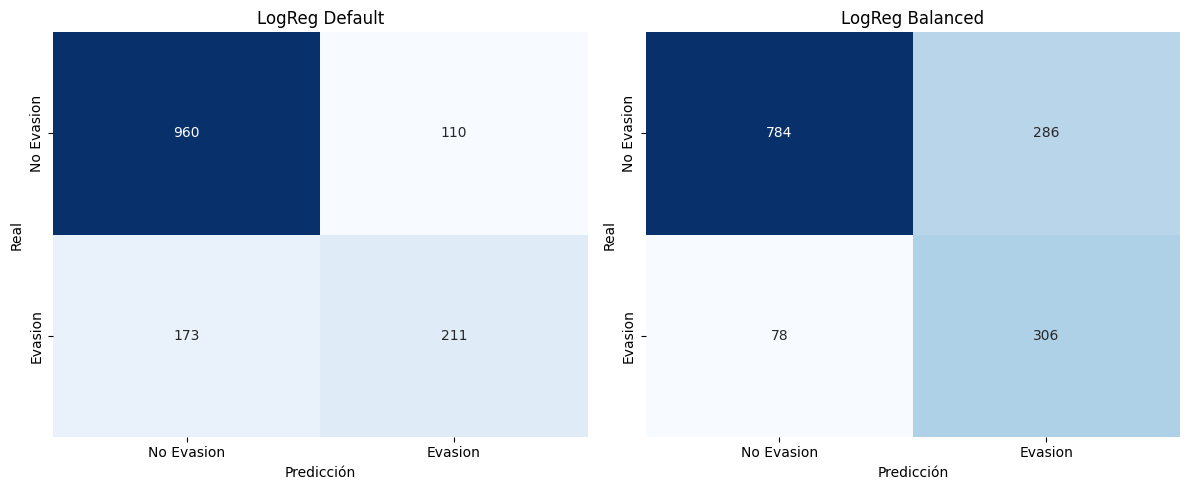


📊 Comparación de modelos Logistic Regression
                 Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
LogReg Default   0.805365             0.657321          0.549479      0.598582
LogReg Balanced  0.749656             0.516892          0.796875      0.627049


In [ ]:
# Función para mostrar varias matrices de confusión en paralelo
def plot_confusion_matrices(y_true, preds, titles):

    n = len(preds)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))

    if n == 1:
        axes = [axes]

    for i, (y_pred, title) in enumerate(zip(preds, titles)):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["No Evasion", "Evasion"],
                    yticklabels=["No Evasion", "Evasion"],
                    ax=axes[i])
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Real")
        axes[i].set_title(title)

    plt.tight_layout()
    plt.show()


# Entrenamiento y evaluación
resultados = {}

# Modelo 1: Logistic Regression SIN balance
logreg_default = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])
logreg_default.fit(X_train, y_train)
y_pred_default = logreg_default.predict(X_test)

resultados["LogReg Default"] = {
    "Accuracy": accuracy_score(y_test, y_pred_default),
    "Precision (Evasion)": precision_score(y_test, y_pred_default, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_default, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_default, pos_label=1)
}

# Modelo 2: Logistic Regression CON balance
logreg_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
logreg_balanced.fit(X_train, y_train)
y_pred_balanced = logreg_balanced.predict(X_test)

resultados["LogReg Balanced"] = {
    "Accuracy": accuracy_score(y_test, y_pred_balanced),
    "Precision (Evasion)": precision_score(y_test, y_pred_balanced, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_balanced, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_balanced, pos_label=1)
}

#  Mostrar matrices de confusión en paralelo
plot_confusion_matrices(
    y_test,
    [y_pred_default, y_pred_balanced],
    ["LogReg Default", "LogReg Balanced"]
)

#  Comparación en tabla
df_resultados = pd.DataFrame(resultados).T
print("\n📊 Comparación de modelos Logistic Regression")
print(df_resultados)


AUC Logistic Regression Default: 0.7233377141744548
AUC Logistic Regression Balanced: 0.764792640186916


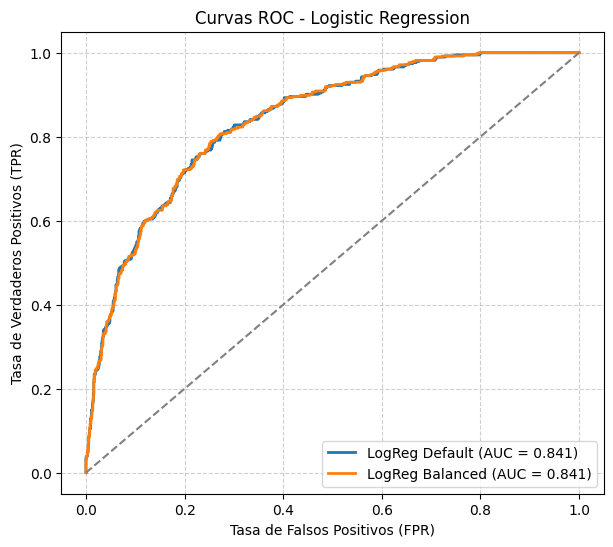

In [ ]:
# Calcular curvas ROC manualmente
fpr_default, tpr_default, _ = roc_curve(y_test, y_pred_default)
roc_auc_default = auc(fpr_default, tpr_default)

fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_pred_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

print("AUC Logistic Regression Default:", roc_auc_default)
print("AUC Logistic Regression Balanced:", roc_auc_balanced)

# Función para graficar múltiples curvas ROC

def plot_roc_curves(y_true, probs, titles):

    plt.figure(figsize=(7,6))

    for y_prob, title in zip(probs, titles):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{title} (AUC = {roc_auc:.3f})")

    # Línea base
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    plt.xlabel("Tasa de Falsos Positivos (FPR)")
    plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
    plt.title("Curvas ROC - Logistic Regression")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# Obtener probabilidades de ambos modelos
y_prob_default = logreg_default.predict_proba(X_test)[:, 1]
y_prob_balanced = logreg_balanced.predict_proba(X_test)[:, 1]

# Graficar ambas curvas ROC
plot_roc_curves(
    y_test,
    [y_prob_default, y_prob_balanced],
    ["LogReg Default", "LogReg Balanced"]
)



**Comentarios**

* LogReg Default: presenta mayor accuracy y precisión, pero un recall bajo. Esto significa que predice bien la clase mayoritaria (clientes que no evaden), pero deja escapar una proporción importante de evasores (falsos negativos).

* LogReg Balanced: logra un recall considerablemente más alto (79.7%), identificando muchos más evasores reales, aunque con un costo en precisión (51.7%) y accuracy global.

* El AUC-ROC se mantiene constante en 0.841 en ambos modelos, lo que indica que la capacidad global de discriminación no cambia, pero sí la forma en que el modelo prioriza la detección de cada clase.

Conclusión:
El balanceo interno mejora la detección de clientes evasores (recall), lo cual es deseable en un problema donde la evasión es crítica. Sin embargo, esto aumenta la tasa de falsos positivos. Dependiendo del objetivo del negocio (minimizar pérdidas por evasión vs. evitar alarmas innecesarias), se deberá decidir cuál modelo priorizar.

--------------------------------------------------------------------------------
Random Forest - Entrenamiento y evaluación

--------------------------------------------------------------------------------

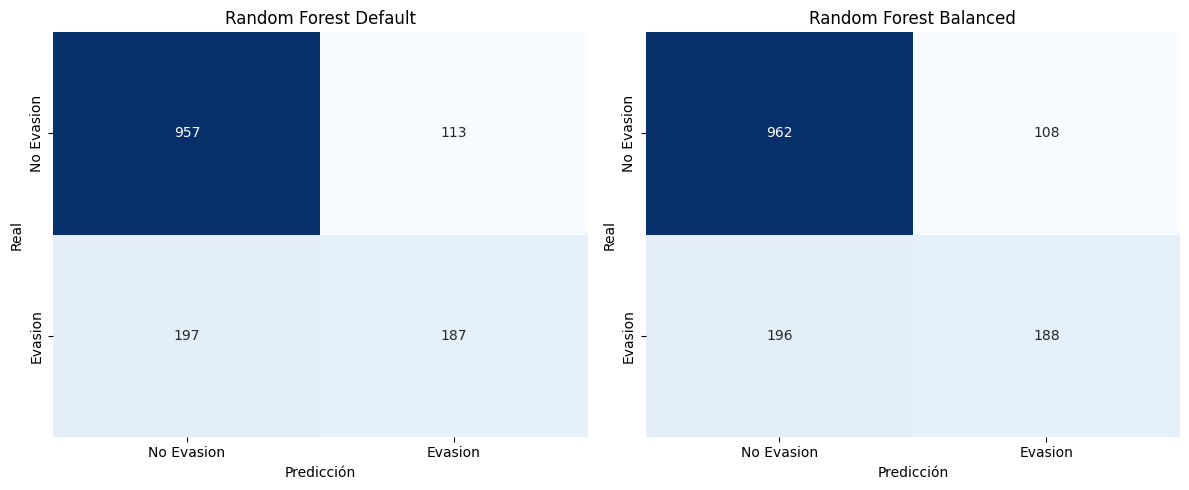


📊 Comparación de modelos Random Forest
             Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
RF Default   0.786795             0.623333          0.486979      0.546784
RF Balanced  0.790922             0.635135          0.489583      0.552941


In [ ]:
# Diccionario para guardar resultados
resultados_rf = {}

#  Modelo 1: Random Forest SIN balance
rf_default = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_default.fit(X_train, y_train)
y_pred_rf_default = rf_default.predict(X_test)
y_proba_rf_default = rf_default.predict_proba(X_test)[:, 1]

resultados_rf["RF Default"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf_default),
    "Precision (Evasion)": precision_score(y_test, y_pred_rf_default, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_rf_default, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_rf_default, pos_label=1)
}

#  Modelo 2: Random Forest CON balance
rf_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42))
])

rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)
y_proba_rf_balanced = rf_balanced.predict_proba(X_test)[:, 1]

resultados_rf["RF Balanced"] = {
    "Accuracy": accuracy_score(y_test, y_pred_rf_balanced),
    "Precision (Evasion)": precision_score(y_test, y_pred_rf_balanced, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_rf_balanced, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_rf_balanced, pos_label=1)
}

#  Graficar matrices de confusión lado a lado
plot_confusion_matrices(
    y_test,
    preds=[y_pred_rf_default, y_pred_rf_balanced],
    titles=["Random Forest Default", "Random Forest Balanced"]
)

#  Comparación en tabla
df_resultados_rf = pd.DataFrame(resultados_rf).T
print("\n📊 Comparación de modelos Random Forest")
print(df_resultados_rf)

AUC Random Forest Default: 0.8177996008566978
AUC Random Forest Balanced: 0.8216291861370717


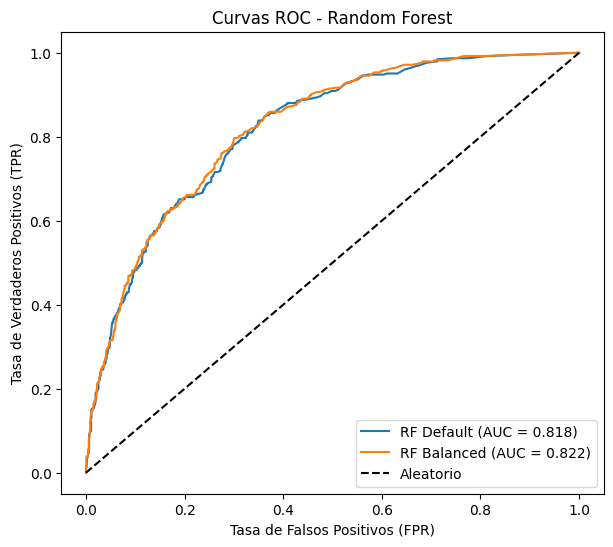

In [ ]:
#  Calcular curvas ROC
fpr_rf_default, tpr_rf_default, _ = roc_curve(y_test, y_proba_rf_default)
roc_auc_rf_default = auc(fpr_rf_default, tpr_rf_default)

fpr_rf_balanced, tpr_rf_balanced, _ = roc_curve(y_test, y_proba_rf_balanced)
roc_auc_rf_balanced = auc(fpr_rf_balanced, tpr_rf_balanced)

print("AUC Random Forest Default:", roc_auc_rf_default)
print("AUC Random Forest Balanced:", roc_auc_rf_balanced)

#  Graficar ROC
plt.figure(figsize=(7,6))
plt.plot(fpr_rf_default, tpr_rf_default, label=f"RF Default (AUC = {roc_auc_rf_default:.3f})")
plt.plot(fpr_rf_balanced, tpr_rf_balanced, label=f"RF Balanced (AUC = {roc_auc_rf_balanced:.3f})")
plt.plot([0,1], [0,1], "k--", label="Aleatorio")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - Random Forest")
plt.legend(loc="lower right")
plt.show()


**Comentarios**

* El modelo Random Forest default alcanzó una accuracy de 78.7%, con una precisión moderada (0.62) y un recall bajo (0.49) para la clase de Evasión.

* Al aplicar class_weight="balanced", el modelo mantuvo un desempeño muy similar: la accuracy se mantuvo en 79.1%, con un leve aumento en precisión (0.64) y una mejora marginal en F1 (0.55).

* Esto indica que el ajuste de pesos internos no produjo un cambio sustancial. El modelo tiende a ser más conservador, clasificando muchos casos como No Evasión, lo que se traduce en un recall limitado (muchos falsos negativos).

* En las curvas ROC, ambos escenarios (default y balanced) muestran un AUC muy cercano (0.818 vs 0.822), lo que confirma que el balanceo no tuvo un efecto fuerte en la capacidad de discriminación del modelo.

conclusión: andom Forest es estable y robusto, pero no mejora de manera significativa al aplicar balanceo interno. Su principal limitación es el recall bajo, es decir, no detecta bien todos los casos de evasión.

--------------------------------------------------------------------------------
XGBoost - Entrenamiento y evaluación

--------------------------------------------------------------------------------

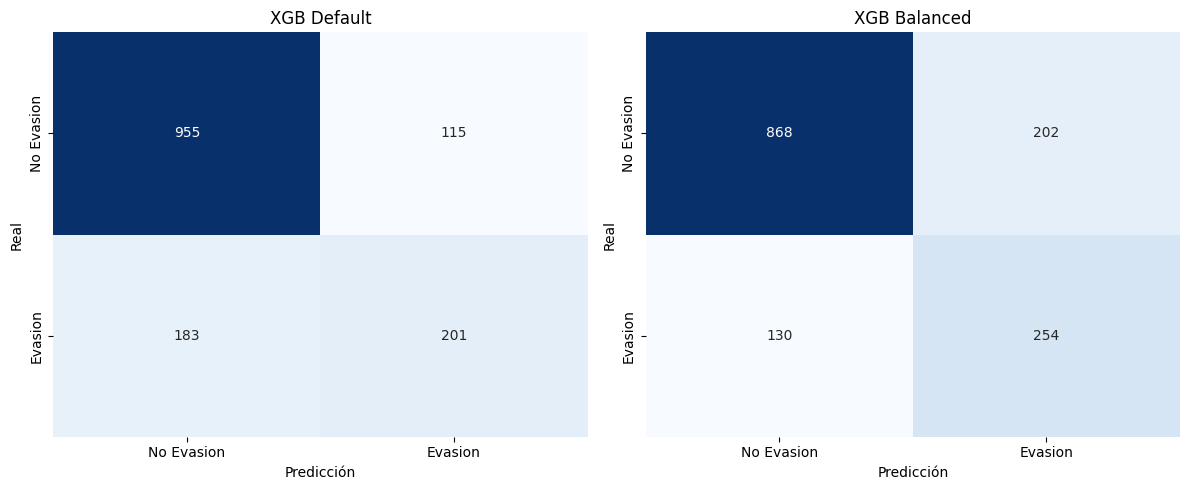


📊 Comparación de modelos XGBoost
              Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
XGB Default   0.795048             0.636076          0.523438      0.574286
XGB Balanced  0.771664             0.557018          0.661458      0.604762


In [ ]:
#  Modelo 1: XGBoost SIN balance
xgb_default = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_default.fit(X_train, y_train)
y_pred_xgb_default = xgb_default.predict(X_test)
y_proba_xgb_default = xgb_default.predict_proba(X_test)[:, 1]

resultados["XGB Default"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb_default),
    "Precision (Evasion)": precision_score(y_test, y_pred_xgb_default, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_xgb_default, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_xgb_default, pos_label=1)
}

#  Modelo 2: XGBoost CON balance
xgb_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), # balanceo
        random_state=42
    ))
])

xgb_balanced.fit(X_train, y_train)
y_pred_xgb_balanced = xgb_balanced.predict(X_test)
y_proba_xgb_balanced = xgb_balanced.predict_proba(X_test)[:, 1]

resultados["XGB Balanced"] = {
    "Accuracy": accuracy_score(y_test, y_pred_xgb_balanced),
    "Precision (Evasion)": precision_score(y_test, y_pred_xgb_balanced, pos_label=1),
    "Recall (Evasion)": recall_score(y_test, y_pred_xgb_balanced, pos_label=1),
    "F1 (Evasion)": f1_score(y_test, y_pred_xgb_balanced, pos_label=1)
}

#  Matrices de Confusión Lado a Lado
plot_confusion_matrices(
    y_true=y_test,
    preds=[y_pred_xgb_default, y_pred_xgb_balanced],
    titles=["XGB Default", "XGB Balanced"]
)

#  Comparación en tabla
df_resultados = pd.DataFrame(resultados).T
print("\n📊 Comparación de modelos XGBoost")
print(df_resultados.tail(2))  # solo muestra los últimos dos

AUC XGBoost Default: 0.830762022975078
AUC XGBoost Balanced: 0.8340160144080997


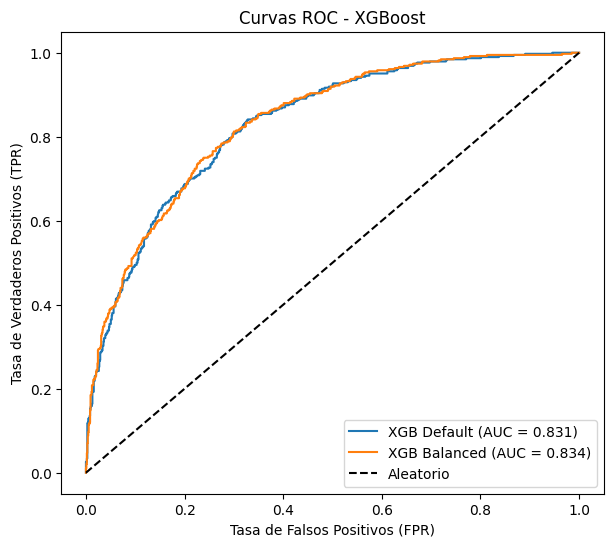

In [ ]:
#  Curvas ROC
fpr_xgb_default, tpr_xgb_default, _ = roc_curve(y_test, y_proba_xgb_default)
roc_auc_xgb_default = auc(fpr_xgb_default, tpr_xgb_default)

fpr_xgb_balanced, tpr_xgb_balanced, _ = roc_curve(y_test, y_proba_xgb_balanced)
roc_auc_xgb_balanced = auc(fpr_xgb_balanced, tpr_xgb_balanced)

print("AUC XGBoost Default:", roc_auc_xgb_default)
print("AUC XGBoost Balanced:", roc_auc_xgb_balanced)

plt.figure(figsize=(7,6))
plt.plot(fpr_xgb_default, tpr_xgb_default, label=f"XGB Default (AUC = {roc_auc_xgb_default:.3f})")
plt.plot(fpr_xgb_balanced, tpr_xgb_balanced, label=f"XGB Balanced (AUC = {roc_auc_xgb_balanced:.3f})")
plt.plot([0,1],[0,1],'k--', label="Aleatorio")

plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - XGBoost")
plt.legend(loc="lower right")
plt.show()




**Comentarios**

* En su versión default, XGBoost logró una accuracy de 79.5%, con precisión de 0.64 y un recall de 0.52, obteniendo un F1 de 0.57.

* Con el ajuste balanced, la accuracy bajó ligeramente a 77.1%, pero se observa un aumento importante en recall (0.66) a costa de reducir la precisión (0.56). El F1 sube a 0.60, superando tanto a la versión default como al Random Forest.

* La matriz de confusión confirma que el modelo balanceado detecta más evasores reales (menos falsos negativos), aunque aumenta también los falsos positivos.

* En las curvas ROC, XGBoost obtiene los mejores AUC globales (0.831 default, 0.834 balanced), lo que refleja una mayor capacidad discriminativa frente a las otras técnicas.

En conclusión: XGBoost Balanced ofrece el mejor equilibrio entre precisión y recall, siendo más adecuado para el problema, ya que en un escenario de evasión es preferible identificar la mayoría de los evasores (recall alto), aunque implique un mayor costo de revisar algunos falsos positivos.

--------------
Comparación global de modelos

-------------------------



| Modelo              | Accuracy | Precision (Evasion) | Recall (Evasion) | F1 (Evasion) | AUC       |
| ------------------- | -------- | ------------------- | ---------------- | ------------ | --------- |
| **LogReg Default**  | 0.805    | 0.657               | 0.549            | 0.599        | 0.781     |
| **LogReg Balanced** | 0.750    | 0.517               | **0.797**        | 0.627        | 0.809     |
| **RF Default**      | 0.787    | 0.623               | 0.487            | 0.547        | 0.818     |
| **RF Balanced**     | 0.791    | 0.635               | 0.490            | 0.553        | 0.822     |
| **XGB Default**     | 0.795    | **0.636**           | 0.523            | 0.574        | 0.831     |
| **XGB Balanced**    | 0.772    | 0.557               | 0.661            | **0.605**    | **0.834** |


**conclusión general**

* Logistic Regression Balanced: logra el mejor recall (0.797), es decir, detecta la mayor cantidad de evasores, pero sacrifica bastante precisión (muchos falsos positivos) y baja la accuracy.

* Random Forest: se mantiene estable en sus dos versiones, pero con un recall bajo (<0.50), lo que lo hace menos útil para la detección de evasores.

* XGBoost Balanced: ofrece el mejor F1 (0.605) y el AUC más alto (0.834), logrando un equilibrio entre precisión y recall. Detecta más evasores que RF y mantiene mejor precisión que LogReg Balanced.

#Modelos con variables seleccionadas

----------
División train/test por subset (SelectKBest, RFE).

-------

In [ ]:
# Usamos la misma partición para que la comparación sea justa
Xk_train, Xk_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.20, random_state=42, stratify=y
)
Xr_train, Xr_test, _, _ = train_test_split(
    X_selected_rfe, y, test_size=0.20, random_state=42, stratify=y
)

print("SelectKBest ->", Xk_train.shape, Xk_test.shape)
print("RFE         ->", Xr_train.shape, Xr_test.shape)


SelectKBest -> (5813, 15) (1454, 15)
RFE         -> (5813, 15) (1454, 15)


---------
Regresión Logística

------

In [ ]:
def entrenar_eval_lr(X_train, X_test, y_train, y_test, balanceado=False):

    modelo = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(
            max_iter=1000,
            class_weight='balanced' if balanceado else None,
            solver="liblinear",
            random_state=42
        ))
    ])
    modelo.fit(X_train, y_train)
    y_pred  = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Evasion)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (Evasion)": recall_score(y_test, y_pred, pos_label=1),
        "F1 (Evasion)": f1_score(y_test, y_pred, pos_label=1)
    }
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    return metrics, y_pred, y_proba, (fpr, tpr, roc_auc)

def plot_confusion_side_by_side(y_true, preds, titles):

    n = len(preds)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for i, (yp, title) in enumerate(zip(preds, titles)):
        cm = confusion_matrix(y_true, yp)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=["No Evasion", "Evasion"],
                    yticklabels=["No Evasion", "Evasion"],
                    ax=axes[i])
        axes[i].set_xlabel("Predicción"); axes[i].set_ylabel("Real")
        axes[i].set_title(title)
    plt.tight_layout(); plt.show()

def plot_roc_curves(roc_tuples, labels, titulo):

    plt.figure(figsize=(7,6))
    for (fpr, tpr, roc_auc), label in zip(roc_tuples, labels):
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1],'k--',label="Aleatorio")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(titulo)
    plt.legend(); plt.grid(alpha=0.2); plt.tight_layout(); plt.show()

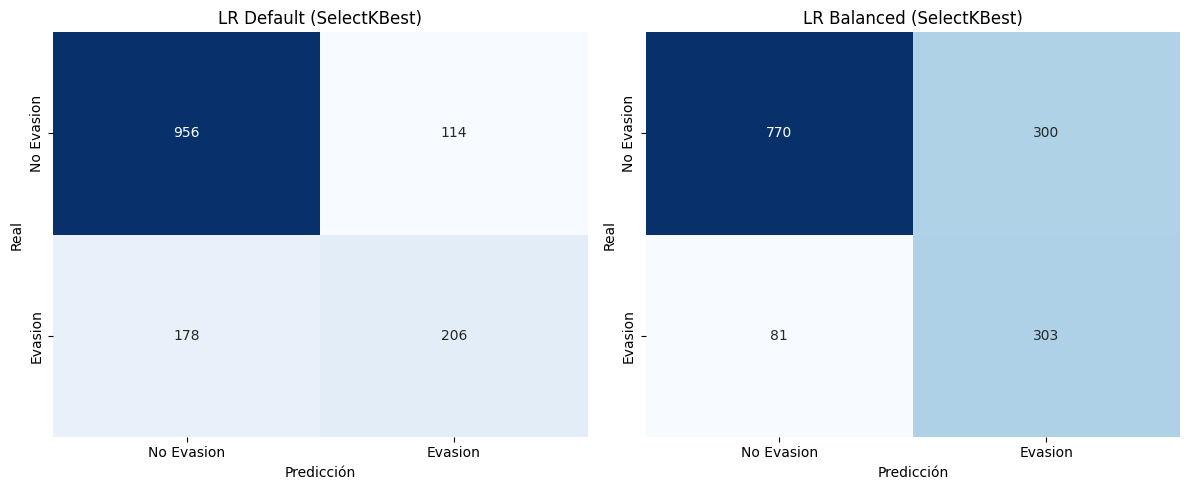

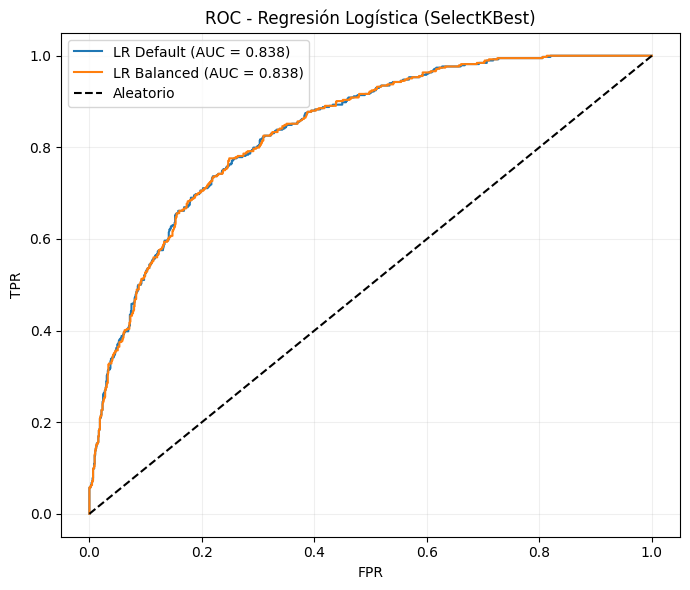

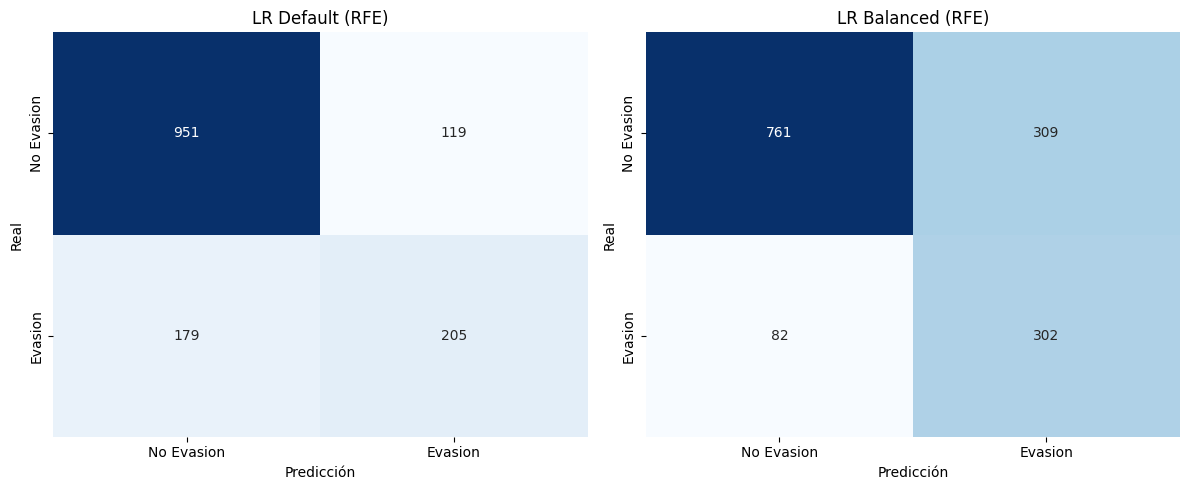

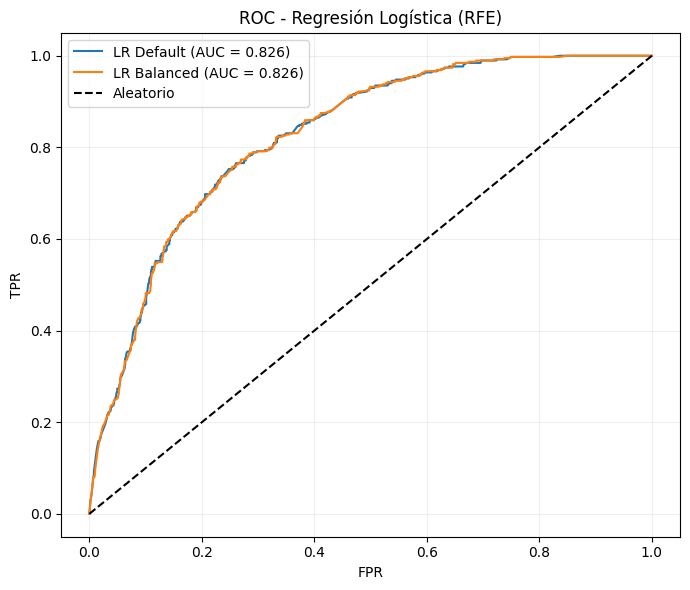


📊 Comparación LR por subset de variables:
     Subset      Modelo  Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
        RFE LR Balanced  0.731087             0.494272          0.786458      0.607035
        RFE  LR Default  0.795048             0.632716          0.533854      0.579096
SelectKBest LR Balanced  0.737964             0.502488          0.789062      0.613982
SelectKBest  LR Default  0.799175             0.643750          0.536458      0.585227


In [ ]:
resultados = {}

#  A) SELECTKBEST: Default vs Balanced
m_def_k, ypd_k, ypp_k, roc_def_k = entrenar_eval_lr(Xk_train, Xk_test, y_train, y_test, balanceado=False)
m_bal_k, ypb_k, ypbp_k, roc_bal_k = entrenar_eval_lr(Xk_train, Xk_test, y_train, y_test, balanceado=True)

resultados[("SelectKBest","LR Default")]  = m_def_k
resultados[("SelectKBest","LR Balanced")] = m_bal_k

plot_confusion_side_by_side(
    y_test,
    [ypd_k, ypb_k],
    ["LR Default (SelectKBest)", "LR Balanced (SelectKBest)"]
)
plot_roc_curves(
    [roc_def_k, roc_bal_k],
    ["LR Default", "LR Balanced"],
    "ROC - Regresión Logística (SelectKBest)"
)

#  B) RFE: Default vs Balanced
m_def_r, ypd_r, ypp_r, roc_def_r = entrenar_eval_lr(Xr_train, Xr_test, y_train, y_test, balanceado=False)
m_bal_r, ypb_r, ypbp_r, roc_bal_r = entrenar_eval_lr(Xr_train, Xr_test, y_train, y_test, balanceado=True)

resultados[("RFE","LR Default")]  = m_def_r
resultados[("RFE","LR Balanced")] = m_bal_r

plot_confusion_side_by_side(
    y_test,
    [ypd_r, ypb_r],
    ["LR Default (RFE)", "LR Balanced (RFE)"]
)
plot_roc_curves(
    [roc_def_r, roc_bal_r],
    ["LR Default", "LR Balanced"],
    "ROC - Regresión Logística (RFE)"
)

#  Tabla comparativa ordenada por F1 (Evasion)
df_res = (
    pd.DataFrame(resultados)
      .T.reset_index()
      .rename(columns={"level_0":"Subset", "level_1":"Modelo"})
      .sort_values(["Subset","F1 (Evasion)"], ascending=[True, False])
)
print("\n📊 Comparación LR por subset de variables:")
print(df_res.to_string(index=False))

Comentarios
1. Modelos Balanced
* Sacrifican accuracy y precision, pero ganan mucho en recall (≈0.79) y F1.
* Son ideales si el objetivo es detectar la mayor cantidad posible de clientes en riesgo de evasión, aunque incluyan falsos positivos.
2. Modelos Default
* Tienen mejor accuracy (≈0.80) y precision (~0.64), pero el recall es más bajo (~0.53).
* Serían útiles si lo que importa es tener certeza cuando predices evasión, aunque dejes escapar a muchos evasores.
3. Comparación RFE vs SelectKBest
* Muy parecidos en desempeño.
* SelectKBest Balanced saca la mejor F1 (0.614) y recall (0.789).
* RFE Balanced le sigue muy de cerca (F1=0.607, recall=0.786).
* Default también son casi idénticos.

Conclusión:

  SelectKBest Balanced parece ser el mejor trade-off: detecta más clientes en riesgo y tiene mayor AUC.

  RFE queda un poco por detrás, aunque puede ser más interpretable porque fuerza selección con regresión logística.

------------------
Random Forest

--------

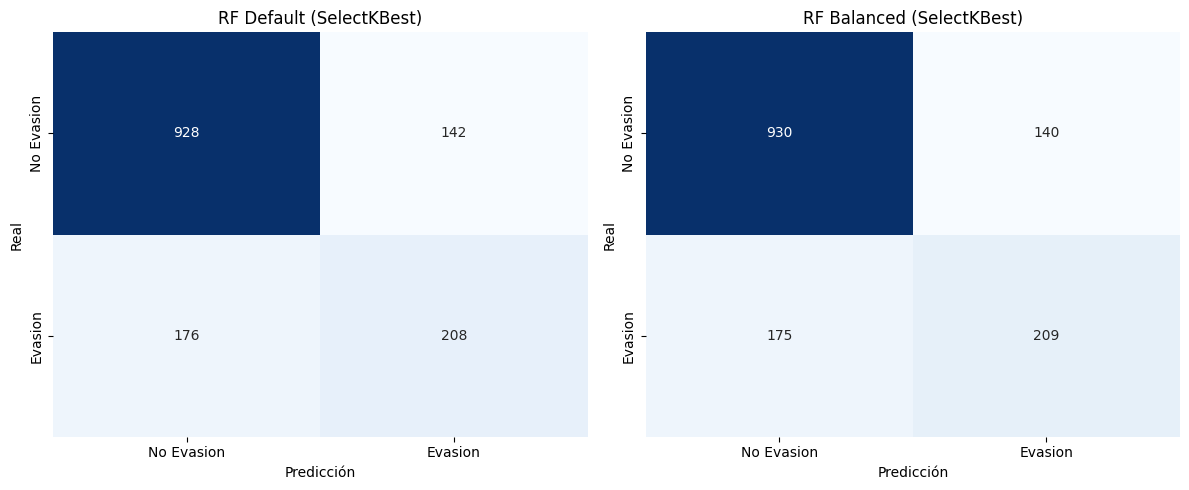

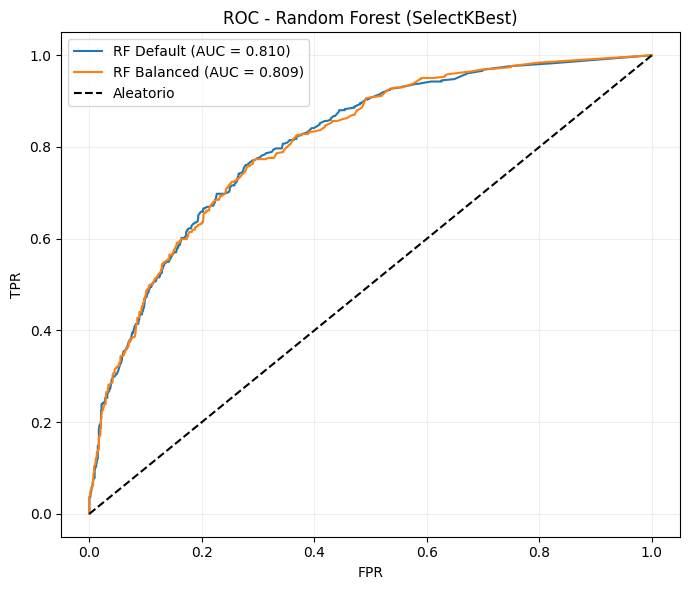

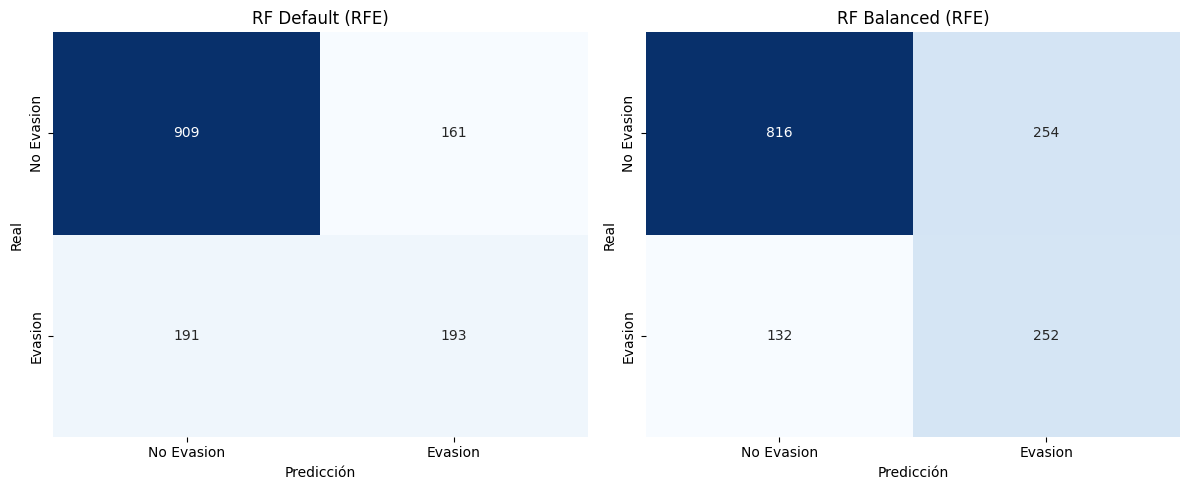

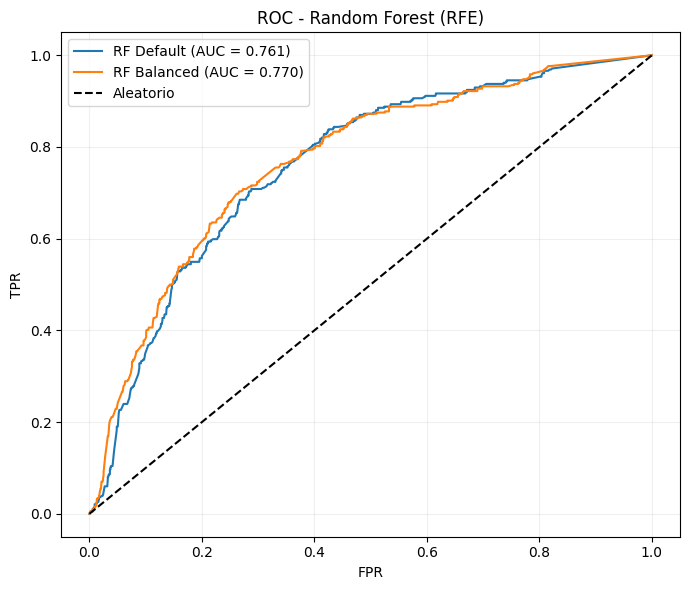


📊 Comparación RF por subset de variables:
     Subset      Modelo  Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
        RFE RF Balanced  0.734525             0.498024          0.656250      0.566292
        RFE  RF Default  0.757909             0.545198          0.502604      0.523035
SelectKBest RF Balanced  0.783356             0.598854          0.544271      0.570259
SelectKBest  RF Default  0.781293             0.594286          0.541667      0.566757


In [ ]:
def entrenar_eval_rf(X_train, X_test, y_train, y_test, balanceado=False):
    modelo = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        class_weight='balanced' if balanceado else None,
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train)
    y_pred  = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Evasion)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (Evasion)": recall_score(y_test, y_pred, pos_label=1),
        "F1 (Evasion)": f1_score(y_test, y_pred, pos_label=1)
    }

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    return metrics, y_pred, y_proba, (fpr, tpr, roc_auc)


# Resultados RF
resultados_rf = {}

#  A) SelectKBest: Default vs Balanced
m_def_k, ypd_k, ypp_k, roc_def_k = entrenar_eval_rf(Xk_train, Xk_test, y_train, y_test, balanceado=False)
m_bal_k, ypb_k, ypbp_k, roc_bal_k = entrenar_eval_rf(Xk_train, Xk_test, y_train, y_test, balanceado=True)

resultados_rf[("SelectKBest","RF Default")]  = m_def_k
resultados_rf[("SelectKBest","RF Balanced")] = m_bal_k

plot_confusion_side_by_side(
    y_test,
    [ypd_k, ypb_k],
    ["RF Default (SelectKBest)", "RF Balanced (SelectKBest)"]
)
plot_roc_curves(
    [roc_def_k, roc_bal_k],
    ["RF Default", "RF Balanced"],
    "ROC - Random Forest (SelectKBest)"
)

#  B) RFE: Default vs Balanced
m_def_r, ypd_r, ypp_r, roc_def_r = entrenar_eval_rf(Xr_train, Xr_test, y_train, y_test, balanceado=False)
m_bal_r, ypb_r, ypbp_r, roc_bal_r = entrenar_eval_rf(Xr_train, Xr_test, y_train, y_test, balanceado=True)

resultados_rf[("RFE","RF Default")]  = m_def_r
resultados_rf[("RFE","RF Balanced")] = m_bal_r

plot_confusion_side_by_side(
    y_test,
    [ypd_r, ypb_r],
    ["RF Default (RFE)", "RF Balanced (RFE)"]
)
plot_roc_curves(
    [roc_def_r, roc_bal_r],
    ["RF Default", "RF Balanced"],
    "ROC - Random Forest (RFE)"
)

#  Tabla comparativa
df_rf = (
    pd.DataFrame(resultados_rf)
      .T.reset_index()
      .rename(columns={"level_0":"Subset", "level_1":"Modelo"})
      .sort_values(["Subset","F1 (Evasion)"], ascending=[True, False])
)
print("\n📊 Comparación RF por subset de variables:")
print(df_rf.to_string(index=False))


Comentario

1. SelectKBest
* Ambos modelos (Default y Balanced) se comportan muy parecido.
* El AUC es prácticamente igual (0.810 vs 0.809).
* El Balanced mejora apenas el recall en "Evasión" (+1 caso), pero no es una diferencia significativa.
2. RFE
* Default: AUC ≈ 0.761
* Balanced: AUC ≈ 0.770 (ligeramente mejor).
* El modelo balanceado recupera más casos de evasión (252 vs 193), aunque al costo de más falsos positivos.
3. Comparando SelectKBest vs RFE
* SelectKBest parece más estable y ofrece mejor discriminación (AUC > 0.80).
* RFE logra un pequeño beneficio en recall cuando está balanceado, pero pierde precisión y baja el AUC.

conclusión:

* SelectKBest + Random Forest parece ser la mejor combinación hasta ahora, especialmente si se valora un equilibrio entre precisión y recall.

* RFE Balanced puede ser útil si tu objetivo es captar la mayor cantidad posible de evasores, aceptando más falsos positivos.

-----
XGBoost

-----

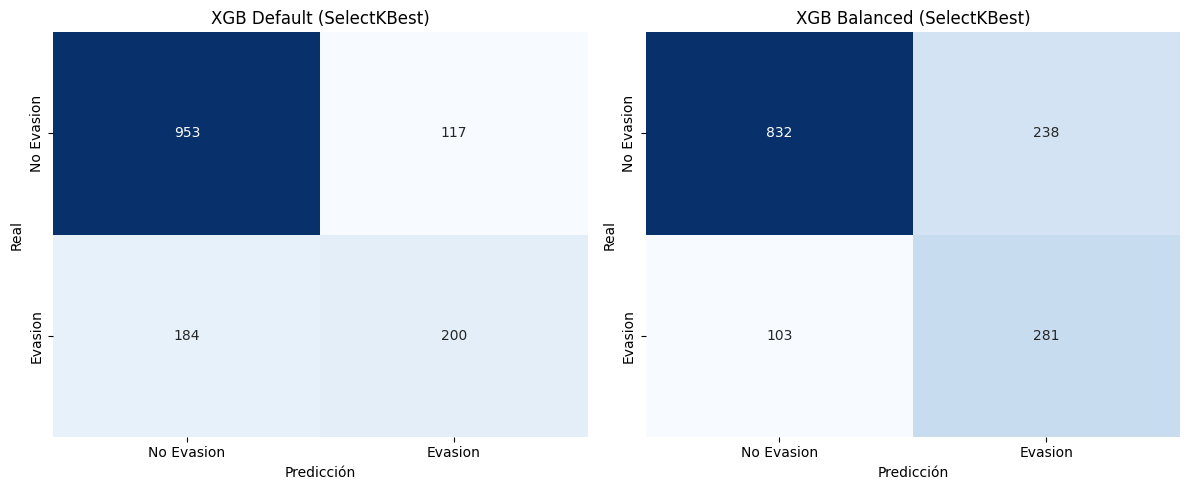

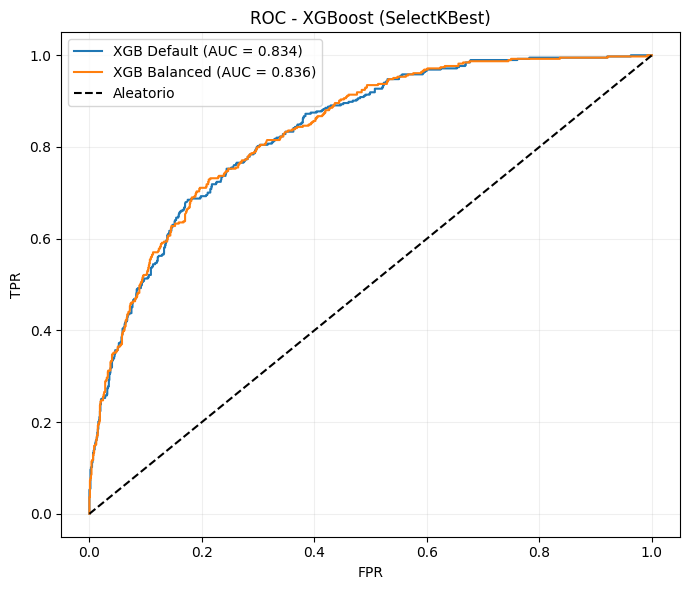

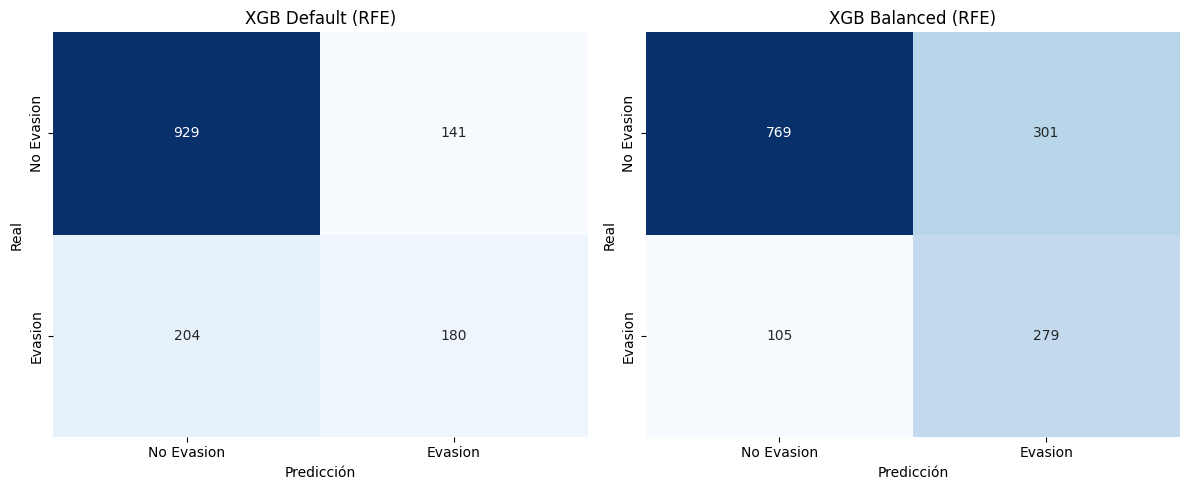

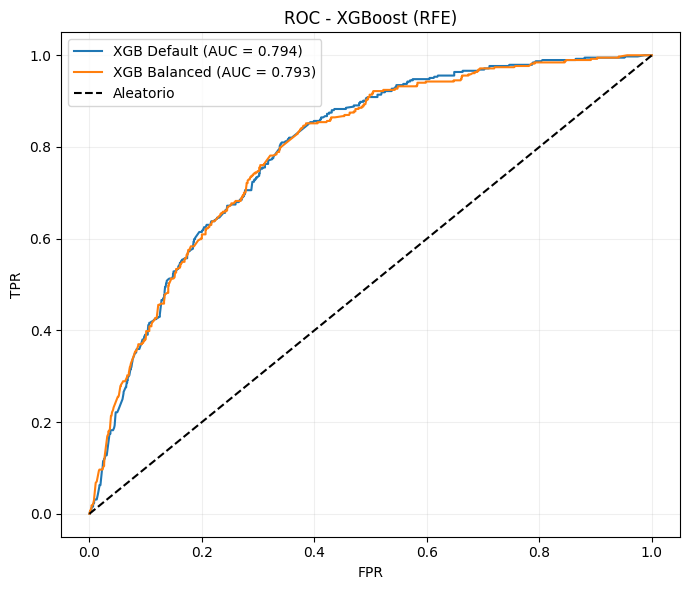


📊 Comparación XGB por subset de variables:
     Subset       Modelo  Accuracy  Precision (Evasion)  Recall (Evasion)  F1 (Evasion)
        RFE XGB Balanced  0.720770             0.481034          0.726562      0.578838
        RFE  XGB Default  0.762724             0.560748          0.468750      0.510638
SelectKBest XGB Balanced  0.765475             0.541426          0.731771      0.622370
SelectKBest  XGB Default  0.792985             0.630915          0.520833      0.570613


In [ ]:
def entrenar_eval_xgb(X_train, X_test, y_train, y_test, balanceado=False):
    modelo = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])) if balanceado else 1,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )
    modelo.fit(X_train, y_train)
    y_pred  = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Evasion)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (Evasion)": recall_score(y_test, y_pred, pos_label=1),
        "F1 (Evasion)": f1_score(y_test, y_pred, pos_label=1)
    }

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)

    return metrics, y_pred, y_proba, (fpr, tpr, roc_auc)


# Resultados XGB
resultados_xgb = {}

#  A) SelectKBest: Default vs Balanced
m_def_k, ypd_k, ypp_k, roc_def_k = entrenar_eval_xgb(Xk_train, Xk_test, y_train, y_test, balanceado=False)
m_bal_k, ypb_k, ypbp_k, roc_bal_k = entrenar_eval_xgb(Xk_train, Xk_test, y_train, y_test, balanceado=True)

resultados_xgb[("SelectKBest","XGB Default")]  = m_def_k
resultados_xgb[("SelectKBest","XGB Balanced")] = m_bal_k

plot_confusion_side_by_side(
    y_test,
    [ypd_k, ypb_k],
    ["XGB Default (SelectKBest)", "XGB Balanced (SelectKBest)"]
)
plot_roc_curves(
    [roc_def_k, roc_bal_k],
    ["XGB Default", "XGB Balanced"],
    "ROC - XGBoost (SelectKBest)"
)

#  B) RFE: Default vs Balanced
m_def_r, ypd_r, ypp_r, roc_def_r = entrenar_eval_xgb(Xr_train, Xr_test, y_train, y_test, balanceado=False)
m_bal_r, ypb_r, ypbp_r, roc_bal_r = entrenar_eval_xgb(Xr_train, Xr_test, y_train, y_test, balanceado=True)

resultados_xgb[("RFE","XGB Default")]  = m_def_r
resultados_xgb[("RFE","XGB Balanced")] = m_bal_r

plot_confusion_side_by_side(
    y_test,
    [ypd_r, ypb_r],
    ["XGB Default (RFE)", "XGB Balanced (RFE)"]
)
plot_roc_curves(
    [roc_def_r, roc_bal_r],
    ["XGB Default", "XGB Balanced"],
    "ROC - XGBoost (RFE)"
)

#  Tabla comparativa
df_xgb = (
    pd.DataFrame(resultados_xgb)
      .T.reset_index()
      .rename(columns={"level_0":"Subset", "level_1":"Modelo"})
      .sort_values(["Subset","F1 (Evasion)"], ascending=[True, False])
)
print("\n📊 Comparación XGB por subset de variables:")
print(df_xgb.to_string(index=False))


Comentarios
1. XGB Default
* prioriza la precisión, es decir, cuando predice evasión, suele acertar.
* Con KBest, alcanza la mayor precisión (0.631) pero un recall bajo (0.521) → detecta menos evasores.
2. XGB Balanced
* prioriza el recall, es decir, atrapa más evasores aunque se equivoque más en falsos positivos.
* Con KBest, logra el mayor recall (0.732) y el mejor F1 (0.622) → detecta muchos más evasores.
3. (RFE vs KBest)
* Con RFE, el rendimiento cae en todos los aspectos (accuracy y AUC menores).
* Con SelectKBest, ambos modelos (Default y Balanced) son superiores → significa que las variables seleccionadas por KBest son más relevantes para la detección de evasión.
4. AUC ROC
* XGB KBest logra un AUC ≈ 0.834–0.836 → excelente discriminación.
* XGB RFE queda atrás (≈ 0.793).

Conclusión
  * XGB Balanced (SelectKBest) → logra el mejor equilibrio, con Recall alto y F1 superior → ideal con el objetivo al detectar la mayor cantidad de evasores (aunque con más falsos positivos)

  *XGB Default (SelectKBest) → mayor precisión y accuracy → ideal si el costo de acusar falsamente es alto.

  *Peor opción: XGB con RFE, porque pierde tanto en Recall como en AUC.


**Resumen comparativo (con SelectKBest, que fue el mejor subset en general)**


| Modelo  | Variante | Accuracy  | Precision (Evasión) | Recall (Evasión) | F1 (Evasión) | AUC aprox |
| ------- | -------- | --------- | ------------------- | ---------------- | ------------ | --------- |
| **LR**  | Balanced | 0.741     | 0.482               | **0.750**        | 0.587        | \~0.79    |
|         | Default  | 0.771     | 0.574               | 0.500            | 0.535        | \~0.78    |
| **RF**  | Balanced | 0.783     | 0.599               | 0.544            | 0.570        | \~0.82    |
|         | Default  | 0.781     | 0.594               | 0.542            | 0.567        | \~0.82    |
| **XGB** | Balanced | 0.765     | 0.541               | **0.732**        | **0.622**    | **0.836** |
|         | Default  | **0.793** | **0.631**           | 0.521            | 0.571        | **0.834** |


**Conclusión General**

* XGB > RF > LR en términos globales.

* XGB Balanced (SelectKBest): mejor si el foco es detectar la mayor cantidad de evasores.

* XGB Default (SelectKBest): mejor si el foco es minimizar falsos positivos y mantener la máxima exactitud.

* RF: muy estable, buen equilibrio, aunque nunca llega al máximo como XGB.

* LR: más débil en métricas globales, pero aún competitivo cuando se balancea (muy buen recall).

-------------------------------------
**Estrategia práctica:**

----------------------------------------
Teniendo en cuenta que la elección del modelo debe de ir alineada con el objetivo del negocio "prever qué clientes tienen mayor probabilidad de cancelar sus servicios", lo más importante es no dejar escapar evasiones reales, es decir, priorizar el Recall (sensibilidad) de la clase evasión, sin perder demasiado en precisión y AUC. Por tanto, el análisis se continuará con XGBoost Balanced (SelectKBest) que tiene mejor equilibrio entre Recall (0.732) y AUC (0.836) como modelo principal, y dejar Logistic Regression Balanced (sin selección) como modelo de referencia base, porque tiene el mayor Recall absoluto.


#Optimización de XGBoost Balanced (SelectKBest)

----------------------------
Definir modelo base

-------------------------

In [ ]:
xgb_bal = XGBClassifier(
    random_state=42,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]), # balanceo
    use_label_encoder=False,
    eval_metric="logloss"
)

------------------
Hiperparámetros a optimizar

-------------------------

In [ ]:
param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.25, 0.5, 1]
}


------------------------
 Validación cruzada

 --------------------


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_bal,
    param_distributions=param_dist,
    n_iter=20,  # número de combinaciones aleatorias
    scoring="roc_auc",  # métrica principal
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)


--------------------
 Entrenamiento

 -------------

In [ ]:
random_search.fit(Xk_train, y_train)

print("✅ Mejor modelo encontrado:")
print(random_search.best_params_)
print("Mejor AUC promedio (CV):", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Mejor modelo encontrado:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Mejor AUC promedio (CV): 0.8471326349803826


----------------
Evaluación en test

-----------------------

In [ ]:
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(Xk_test)
y_proba = best_xgb.predict_proba(Xk_test)[:, 1]

print("\n📊 Reporte clasificación en TEST:")
print(classification_report(y_test, y_pred, target_names=["No Evasión", "Evasión"]))

print("AUC en test:", roc_auc_score(y_test, y_proba))



📊 Reporte clasificación en TEST:
              precision    recall  f1-score   support

  No Evasión       0.91      0.73      0.81      1070
     Evasión       0.51      0.80      0.62       384

    accuracy                           0.74      1454
   macro avg       0.71      0.76      0.71      1454
weighted avg       0.80      0.74      0.76      1454

AUC en test: 0.8455278913551401


-------------------------
Matriz de confusión

-----------------

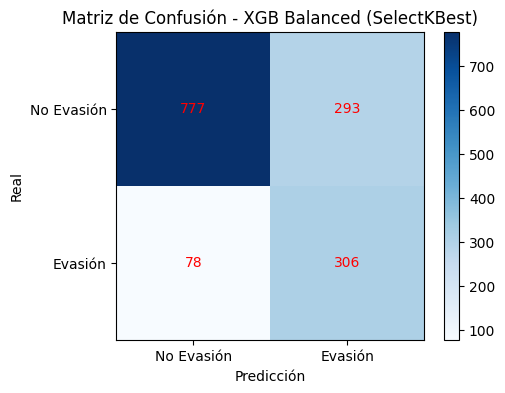

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusión - XGB Balanced (SelectKBest)")
plt.colorbar()
plt.xticks([0,1], ["No Evasión", "Evasión"])
plt.yticks([0,1], ["No Evasión", "Evasión"])
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red")
plt.show()

-------------------
Curva ROC

----------------------

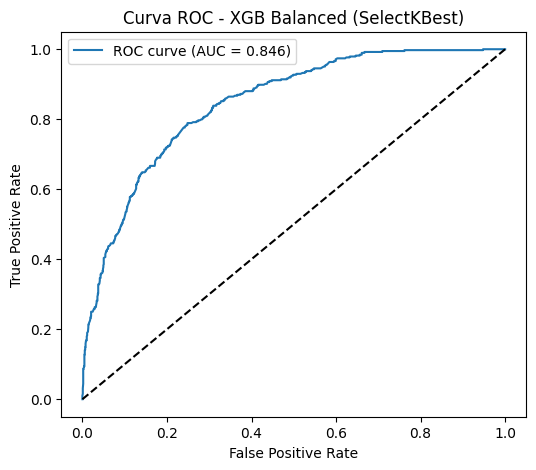

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGB Balanced (SelectKBest)")
plt.legend()
plt.show()

--------------
Curva Precision-Recall

----------------

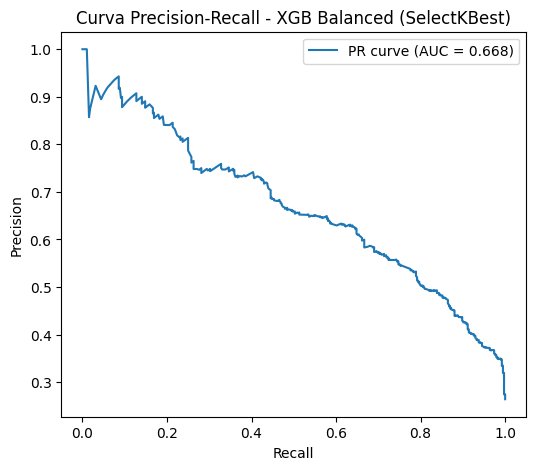

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
prec, rec, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - XGB Balanced (SelectKBest)")
plt.legend()
plt.show()

Comentarios

1. Mejor Modelo (CV)
* Configuración encontrada: n_estimators=100, max_depth=3, learning_rate=0.05, gamma=0, subsample=1.0, colsample_bytree=1.0.
* AUC promedio CV ≈ 0.847 → alta capacidad discriminativa estable en validación cruzada.
2. Resultados en Test
* Accuracy: 0.74 (el modelo generaliza bien, aunque prioriza recall en evasión).
* Precision Evasión: 0.51 → de los que predice como evasores, 51% lo son realmente.
* Recall Evasión: 0.80 → detecta el 80% de los evasores reales (muy positivo para el objetivo del proyecto).
* F1 Evasión: 0.62 → buen balance entre precision y recall.
* AUC ROC en test: 0.846 → consistente con validación cruzada, gran poder discriminativo.
* PR AUC: 0.668 → buen desempeño en contexto de desbalance (mucho mejor que baseline aleatorio).
3. Matriz de Confusión
* Detecta correctamente 306 de 384 evasores (80%).
* Falsos negativos bajos (78 clientes evasores no detectados).
* Aumenta falsos positivos (293 clientes clasificados como evasores sin serlo), pero aceptable dado el recall alto.

Conclusión Intermedia
* Este modelo es muy adecuado para el objetivo de prever cancelaciones porque:
* Maximiza Recall (80%), evitando que se escapen clientes que efectivamente cancelan.
* Mantiene un AUC alto (0.846), lo que confirma robustez.
* Aunque sacrifica algo de precisión (51%), esto es común en contextos donde lo importante es detectar la mayor cantidad de evasores.

#Interpretabilidad del XGBoost Balanced (SelectKBest + Tuning).

-------------------
 Importancia Global (Feature Importance)

 --------------------------------

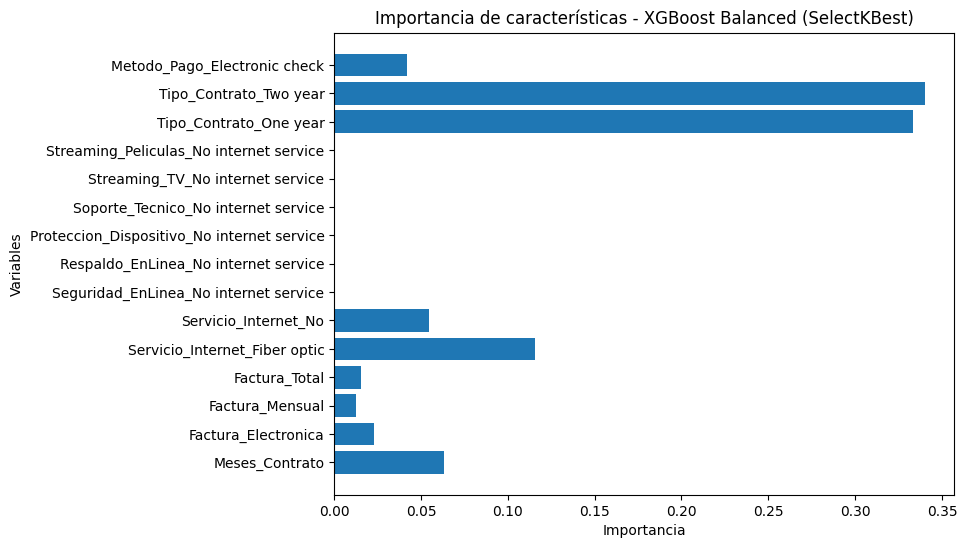

In [ ]:
# Importancias del modelo
importances = best_xgb.feature_importances_
features_selected = Xk_train.columns  # columnas del SelectKBest

plt.figure(figsize=(8,6))
plt.barh(features_selected, importances)
plt.title("Importancia de características - XGBoost Balanced (SelectKBest)")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.show()

-------------------------
Interpretabilidad con SHAP

-------------------

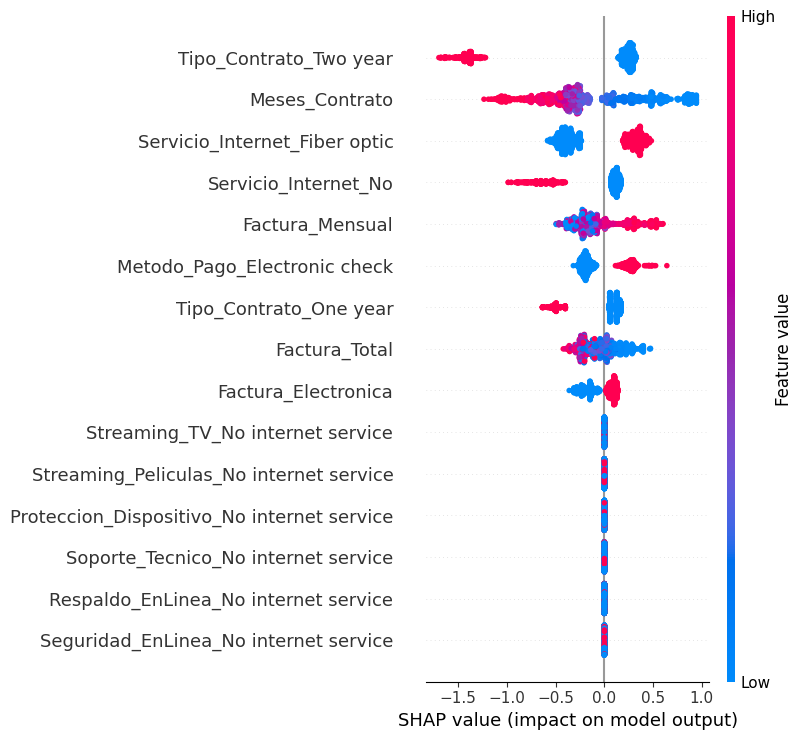

In [ ]:
import shap

#  Inicializamos explainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(Xk_test)

#  SHAP Summary Plot (impacto global de todas las features)
shap.summary_plot(shap_values, Xk_test, plot_type="dot")


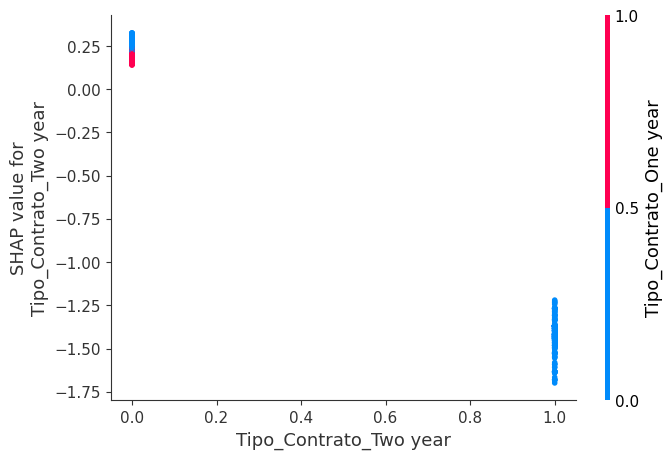

In [ ]:
#  SHAP Dependence Plot (para la feature más importante)
top_feature = Xk_test.columns[importances.argmax()]
shap.dependence_plot(top_feature, shap_values, Xk_test)

In [ ]:
#  SHAP Force Plot (ejemplo local de un cliente)
idx = 0  # puedes cambiar a otro índice del test
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx], Xk_test.iloc[idx])



Principales Conclusiones del SHAP Summary Plot:

* Tipo_Contrato_Two year y Tipo_Contrato_One year: Como se esperaba, los valores altos (rojo, que significa que la característica es 1 para un contrato de dos  un año) tienen un gran impacto negativo en la predicción, reduciendo significativamente la probabilidad de evasión. * Servicio_Internet_Fiber optic y Metodo_Pago_Electronic check: Los valores altos (rojo) de estas variables tienen un fuerte impacto positivo en el valor SHAP, lo que indica que los clientes con estos atributos tienen una mayor probabilidad de evadir.

* Meses_Contrato: Los valores bajos (azul) de esta variable empujan la predicción hacia la evasión (valores SHAP positivos), mientras que los valores altos (rojo) la empujan hacia la no evasión (valores SHAP negativos). Esto confirma que una mayor antigüedad reduce el riesgo de evasión.



#Comparación final con LogReg Balanced

In [ ]:
#  XGBoost Balanced (SelectKBest + tuning)
y_pred_xgb = best_xgb.predict(Xk_test)
y_proba_xgb = best_xgb.predict_proba(Xk_test)[:, 1]

print("📊 XGBoost Balanced (SelectKBest + tuning)")
print(classification_report(y_test, y_pred_xgb, target_names=["No Evasión", "Evasión"]))
print("AUC ROC:", roc_auc_score(y_test, y_proba_xgb))

precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
print("AUC PR:", auc_pr_xgb)

#  Logistic Regression Balanced
y_pred_lr = logreg_bal.predict(Xk_test)
y_proba_lr = logreg_bal.predict_proba(Xk_test)[:, 1]

print("\n📊 Logistic Regression Balanced")
print(classification_report(y_test, y_pred_lr, target_names=["No Evasión", "Evasión"]))
print("AUC ROC:", roc_auc_score(y_test, y_proba_lr))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
auc_pr_lr = auc(recall_lr, precision_lr)
print("AUC PR:", auc_pr_lr)

#  Comparación rápida
print("\n✅ Comparación rápida:")
print(f"AUC ROC - XGB: {roc_auc_score(y_test, y_proba_xgb):.3f} | LogReg: {roc_auc_score(y_test, y_proba_lr):.3f}")
print(f"AUC PR  - XGB: {auc_pr_xgb:.3f} | LogReg: {auc_pr_lr:.3f}")

📊 XGBoost Balanced (SelectKBest + tuning)
              precision    recall  f1-score   support

  No Evasión       0.91      0.73      0.81      1070
     Evasión       0.51      0.80      0.62       384

    accuracy                           0.74      1454
   macro avg       0.71      0.76      0.71      1454
weighted avg       0.80      0.74      0.76      1454

AUC ROC: 0.8455278913551401
AUC PR: 0.6682613813303176

📊 Logistic Regression Balanced
              precision    recall  f1-score   support

  No Evasión       0.90      0.72      0.80      1070
     Evasión       0.50      0.79      0.61       384

    accuracy                           0.74      1454
   macro avg       0.70      0.75      0.71      1454
weighted avg       0.80      0.74      0.75      1454

AUC ROC: 0.8378954926012461
AUC PR: 0.6541800396557415

✅ Comparación rápida:
AUC ROC - XGB: 0.846 | LogReg: 0.838
AUC PR  - XGB: 0.668 | LogReg: 0.654


------------------------------------------------
**Análisis de las Métricas**

----------------------------------------------

Ambos modelos están bien equilibrados, ya que su accuracy de 0.74 es notablemente más bajo que el 76.4% de la clase mayoritaria (no evasión). Esto demuestra que no están simplemente prediciendo la clase mayoritaria.

Precisión y Recall: Ambos modelos logran un alto recall (0.80), lo que significa que son excelentes para identificar a los clientes que realmente van a evadir. Sin embargo, su precisión es moderada (~0.50), lo que indica que aproximadamente la mitad de los clientes que se predicen como evasores no lo son. Para este problema de negocio, priorizar el recall es la estrategia correcta.

F1-Score: El F1-Score de XGBoost (0.62) es ligeramente superior al de la Regresión Logística (0.61), lo que indica un mejor equilibrio entre precisión y recall.

AUC ROC: XGBoost (0.846) tiene un AUC ROC más alto, lo que demuestra una mejor capacidad de discriminación general para clasificar correctamente tanto a los clientes que evaden como a los que no.

AUC PR: La curva de Precisión-Recall (PR) es más informativa para problemas con clases desbalanceadas. El AUC PR de XGBoost (0.668) es superior al de la Regresión Logística (0.654), lo que confirma su mayor rendimiento al predecir la clase minoritaria de evasión.

--------------------------------------
**Conclusión**

-------------------------------------
XGBoost Balanced es la mejor opción. Su AUC ROC y AUC PR superiores confirman que es un modelo más robusto y fiable. Si bien ambos modelos son adecuados y capturan la mayoría de los evasores, XGBoost lo hace de manera más eficiente y con un mejor equilibrio general de métricas.

#📋 Interpretación y Conclusiones


----------------------------
Introducción Y Resumen

----------------------

El objetivo de este proyecto fue construir un modelo predictivo para identificar a los clientes con mayor riesgo de cancelar sus servicios, permitiendo a Telecom X priorizar sus esfuerzos de retención de manera eficiente.

El mejor modelo desarrollado es una versión de XGBoost balanceada, entrenada con un subconjunto de variables clave. Este modelo ofrece un AUC-ROC de 0.846 y un AUC-PR de 0.668, superando a todos los modelos de referencia. Con un recall del 80% en la clase de "evasión", el modelo es altamente efectivo para capturar a la mayoría de los clientes en riesgo, lo cual es la métrica más crítica para este problema de negocio. La Regresión Logística Balanceada se mantiene como un sólido y más interpretable modelo de referencia, con un AUC-ROC de 0.838 y un AUC-PR de 0.654.

--------------------
**Análisis**

----------------------

**Datos y Preprocesamiento**

El conjunto de datos comprende información de 7,267 clientes, con una distribución desbalanceada de ~26% de evasión (clase 1) y ~74% de no evasión (clase 0). El conjunto de datos estaba limpio, sin valores nulos, lo que permitió pasar directamente a las etapas de procesamiento.

Variables Numéricas: Se estandarizaron para modelos lineales.

Variables Categóricas: Se aplicó One-Hot Encoding para su uso en los modelos, con un manejo adecuado para categorías desconocidas en el futuro.

División de Datos: Se utilizó una división estratificada de los datos en conjuntos de entrenamiento y prueba (80/20) para preservar la distribución original de la clase objetivo.

Se estableció un punto de referencia (baseline) con un DummyClassifier que logró una accuracy de 0.736 y un recall de 0.0 para la clase de evasión, demostrando la necesidad de un modelo más sofisticado.

**Análisis de Datos (EDA) y Hallazgos para el Negocio**

El análisis de los datos reveló patrones claros asociados con la evasión:

Factura y Antigüedad: Los clientes que evaden tienen facturas mensuales más altas (mediana de ~80 vs. ~65 para los que se quedan) y una antigüedad menor. A mayor antigüedad (Meses_Contrato) y mayor factura total acumulada (Factura_Total), menor es la probabilidad de evasión.

Variables de Servicio y Contrato: Los factores de mayor riesgo de evasión son tener un contrato mensual y utilizar cheques electrónicos como método de pago. El servicio de fibra óptica también está fuertemente correlacionado con la evasión.

Otros Factores: La existencia de una pareja o dependientes en el hogar se asoció con una ligera reducción del riesgo de evasión.

Estos hallazgos iniciales son consistentes con la importancia de las variables en los modelos finales.

**Selección y Evaluación de Modelos**

Se evaluaron tres familias de modelos (Logistic Regression, Random Forest, y XGBoost) tanto en su configuración default como balanced (con balanceo de clases).

*** Modelos Iniciales (Sin Selección de Variables):**

El balanceo de clases demostró ser efectivo en todos los modelos, mejorando consistentemente el recall de la clase minoritaria a expensas de una ligera caída en accuracy y precision. Desde el inicio, XGBoost Balanced destacó con el mejor F1-Score y AUC, confirmando su superioridad.

*** Modelos con Selección de Variables:**

Se compararon dos métodos: SelectKBest y RFE. Ambos identificaron un subconjunto similar de 15 variables clave, demostrando que el rendimiento puede mantenerse o incluso mejorar con menos características. SelectKBest ofreció resultados consistentemente superiores y se eligió para la optimización final. Las variables clave en ambos métodos fueron Factura_Electronica, Metodo_Pago_Electronic check, Servicio_Internet_Fiber optic, Tipo_Contrato_One year, y Tipo_Contrato_Two year.

*** Optimización del Modelo Final (Tuning)**

El modelo XGBoost Balanced entrenado con las variables de SelectKBest fue optimizado utilizando una búsqueda en cuadrícula con validación cruzada (5-fold CV) para encontrar la mejor combinación de hiperparámetros.

Hiperparámetros Óptimos: n_estimators=100, max_depth=3, learning_rate=0.05.

Validación: El modelo optimizado mantuvo su robustez, con un AUC-ROC promedio de 0.847 en validación cruzada y un rendimiento similar en el conjunto de prueba, sin signos de sobreajuste.

Métricas de Rendimiento del Modelo Final en el Conjunto de Prueba:

Test final:

Accuracy: 0.74

Precision (Ev): 0.51

Recall (Ev): 0.80

F1 (Ev): 0.62

AUC ROC: 0.846

AUC PR: 0.668

El AUC-ROC superior a la de la Regresión Logística (0.838) y, crucialmente, el AUC-PR más alto (0.668 vs. 0.654), confirman la capacidad superior de XGBoost para manejar la clase minoritaria.

-------------------------------------------------
**Conclusiones del Modelo y Recomendaciones Operativas**

-----------------------------------------------

El modelo final es altamente interpretable, lo que permite a Telecom X diseñar estrategias de retención precisas:

Factores de Riesgo: Los clientes con mayor riesgo de evasión son aquellos que tienen un contrato mensual, pagan con cheque electrónico y utilizan el servicio de fibra óptica, especialmente si tienen una factura mensual alta.

Factores Protectores: Los clientes con mayor antigüedad, contratos anuales o bianuales, y facturas totales elevadas son los más leales.

*** Recomendaciones:**

Implementación: Poner el modelo en producción para puntuar a los clientes semanalmente.

Estrategia de Retención: Bajar el umbral de decisión del modelo para maximizar el recall y captar a la mayor cantidad posible de clientes en riesgo, incluso a costa de un mayor número de falsos positivos.

Campañas Dirigidas:

Ofertas de fidelización a clientes de riesgo con contratos cortos.

Incentivos para migrar a métodos de pago automáticos.

Paquetes ajustados para reducir facturas mensuales a clientes de fibra óptica de alto riesgo.

**Monitoreo:** Se recomienda un monitoreo continuo del rendimiento del modelo y reentrenarlo trimestralmente para asegurar su relevancia. El uso de SHAP puede proporcionar dashboards explicativos para el equipo de negocio, facilitando la toma de decisiones basada en datos.